# Atmosphere Plotter Notebook. Version 3. AggregateRandomPhases

----
### Aggregate Random Phases

#### This notebook take instances of production1_randomPhase1-5 to generate averaged-variability + color-inclination trends.
----

### readme: problem statement, step listing, scenarios names

This notebook read the spectral datacubes generated by `PolarVortice/AtmosphereGenerator.py`.

The datacubes are located at `PolarVortice/output/`. In this script, I configured it to read only `production` datacubes.

1. **Step 1**: Read Spectral Monitoring Data 
2. **Step 2**: Generate Synthetic Spectra Cube with Sonora
3. **Step 3**: Reproduce Color-inclination plots
4. **Step 4**: Replot for the scenario No Vortex/nothing.
5. **Step 5**: Reproduce variability-inclination plots

----
Scenario names crossmatch with Fuda et al. 2024b: The scenario name in this code is different from the journal paper.
- `'nothing'`:     is the same as `'No Vortex'`
- `'polarStatic'`: is the same as `'Evolving Vortex'`
- `'noPolar'`:     is the same as `'Static Vortex'`
----

#### Step 0: Initialization

In [1]:
import astropy.constants as c
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import os
import re
import h5py
from astropy.convolution import convolve, Box1DKernel
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib
import scipy as sp
import scipy.interpolate

matplotlib.rcParams.update({'font.size': 12})

In [2]:
### ========= function to print levels of nested dicts =================
def print_nested_dict(d, indent=0):
    for key, value in d.items():
        print("  " * indent + str(key) + ":")
        if isinstance(value, dict):
            print_nested_dict(value, indent + 1)
        else:
            print("  " * (indent + 1) + str(value))

### ========= lamda function to create nested_dict ======================
nested_dict = lambda: defaultdict(nested_dict)

### ========= function to bring array value to one ======================
def bring_to_one(array):
    shift = (array.max() + array.min())/2
    return 1 + array - shift

### ========= itertools to generated random marker =====================
import itertools
markerRandomList = itertools.cycle((',', '+', '.', 'o', '*'))
linestyleRandomList = itertools.cycle(('--', '-', '-.', ':', ''))
### Usage
# for n in y:
#     plt.plot(x,n, marker = next(marker), linestyle='')

### =========  Function to do log-log interpolation =====================
def log_interp1d(xx, yy, kind='linear'):
    logx = np.log10(xx)
    logy = np.log10(yy)
    lin_interp = sp.interpolate.interp1d(logx, logy, kind=kind)
    log_interp = lambda zz: np.power(10.0, lin_interp(np.log10(zz)))
    return log_interp

### =========  Path to save plot figures ================================
plotPath = '/Users/nguyendat/Documents/GitHub/polar_vortice/PolarVortice/AtmopsherePlotterOutputPlots/'

## Step 1: Read Spectral Monitoring Data Cube

#### Initialization

- Choose class of models to read.
- model_class, model_id, inclination, starting_time, end_time, frame_numbers
- data structure:

dict:static|dynamic|nopolar|
=> dict:inclination_value:'string' 
=> dict:time_value:'string' 
=> numpy:gray_array:2d_image

- aggregate all instances of production1 with different phase offsets

#### 1A) [read, print] Read files into 1 dictionary contain 2 classes: Polar_static, NoPolar

In [3]:
directory = "/Users/nguyendat/Documents/GitHub/polar_vortice/PolarVortice/output/"
production_list = []
foldernameLists = []
other_list = []

productionKey = 'production1_phaseRandomized'

print('============================================================')
print('Production key: "%s"'%productionKey)
print('\nThe production datacubes includes:')
for foldername in os.listdir(directory):
    if productionKey in foldername and 'polarDynamic' not in foldername:
        print(foldername)
        foldernameLists.append(foldername)
        production_list.append(directory+foldername+'/')
    else:
        other_list.append(directory+foldername+'/')
print('============================================================')
print('\n')

production_keys = []
for s in foldernameLists:
    match = re.search(r'\[([^\]]+)\]', s)
    production_keys.append(match.group(1))
        
production_keys = sorted(list(set(production_keys)))

# ================================================================
# Function to categorize file names
# ================================================================
def categorize_filenames(directory_list):
    # create empty, pre-nested dicts
    datacubes = nested_dict()
    metadatas = nested_dict()
    
    for directory in directory_list:
        # Iterate over files in the directory
        for filename in os.listdir(directory):
            # print(filename)
            # Check if the file is a H5 file
            if filename.endswith(".h5"):
                parts = re.findall("\[(.*?)\]", filename)
                model_id = str(parts[1])
                class_name = str(parts[0])
                incli_value = str(parts[2])
                t1t2FrameNo_value = parts[3] + "-" + parts[4] + "-" + parts[5]

                # Load numpy array from H5 file
                with h5py.File(os.path.join(directory, filename), 'r') as f:
                    data = f['dataset'][:]
                    datacubes[model_id][class_name][incli_value][t1t2FrameNo_value] = data
            
            # Check if the file is a pickle file
            if filename.endswith(".pkl"):
                parts = re.findall("\[(.*?)\]", filename)
                model_id = parts[2]
                class_name = parts[1]
                incli_value = parts[3]
                t1t2FrameNo_value = parts[4] + "-" + parts[5] + "-" + parts[6]

                # Load metadata from pickle file
                with open(os.path.join(directory, filename), 'rb') as f:
                    data = pickle.load(f)
                    metadatas[model_id][class_name][incli_value][t1t2FrameNo_value] = data
                    
    return datacubes, metadatas

# read the production datacube
datacubes, metadatas = categorize_filenames(production_list)
print('Done reading the production datacubes')

Production key: "production1_phaseRandomized"

The production datacubes includes:
dataCube[production1_phaseRandomized1][noPolar][i][0][60][60]
dataCube[production1_phaseRandomized5][noPolar][i][0][60][60]
dataCube[production1_phaseRandomized5][polarStatic][i][0][60][60]
dataCube[production1_phaseRandomized4][polarStatic][i][0][60][60]
dataCube[production1_phaseRandomized1][polarStatic][i][0][60][60]
dataCube[production1_phaseRandomized2][noPolar][i][0][60][60]
dataCube[production1_phaseRandomized2][polarStatic][i][0][60][60]
dataCube[production1_phaseRandomized4][noPolar][i][0][60][60]
dataCube[production1_phaseRandomized3][noPolar][i][0][60][60]
dataCube[production1_phaseRandomized3][polarStatic][i][0][60][60]


Done reading the production datacubes


In [4]:
# ============================================================
# Print bookkeeping information
# ============================================================
display_bookkeep = False
# display_bookkeep = True

for productionKey in production_keys:

    modelclasses = []
    modelclasses = list(datacubes[productionKey].keys())
    if display_bookkeep:
        print('============================================================')
        print('--> production name:', productionKey)

    for model in modelclasses:
        incli = list(datacubes[productionKey][model].keys())
        incli = sorted([int(x) for x in incli]) 
        incli = [str(x) for x in incli]

        photo_config = list(datacubes[productionKey][model][incli[0]].keys())
        
        # =======================================================
        # Choose which photometry configuration to use: 
        # Currently photo_config
        # =======================================================

        for config in photo_config:
            if config == '0-60-60':
                
                photo_config0 = config
                # print('\n--> Using the photometry config: [%s] (t0-t1-no_frame)'%photo_config0)
                if display_bookkeep:
                    print('----> [%s] contains these inclination'%model, sorted(incli))

                    randphasevalue = metadatas[productionKey][model]['0'][photo_config0]['randPhase']
                    print('---------> Random phases at each inclination:')
                    for line in randphasevalue:
                          print('---------> ', line[0], ':', line[1])
                      
                metakeys = list(metadatas[productionKey][model][incli[0]][photo_config0].keys())
                no_frame = datacubes[productionKey][model][incli[0]][photo_config0].shape[0]
                t0, t1 = int(photo_config0.split('-')[0]), int(photo_config0.split('-')[1])

                time_array = np.linspace(t0, t1-1, no_frame) 

    # print('\n--> The metadata contains these attributes: \n', metakeys)
    # print('============================================================')

In [5]:
incli

['-90', '-80', '-70', '-60', '-50', '-40', '-30', '-20', '-10', '0']

#### 1B) [plot] Photometry and specmaps 

In [6]:
# ============================================================
# [[Plot]]
# Plot the first photometry-frame, spectra-map for one inclin
# of each model class
# ============================================================

photo_config0 = '0-60-60'
# photo_config0 = '0-30-30'
no_frame = datacubes[productionKey][model][incli[0]][photo_config0].shape[0]

%matplotlib inline
plt.close('all')
for iang in ['-20', '-60']:
    # fig, axs = plt.subplots(1, 3, dpi=120, figsize=(9,3))
    cadence = (t1-t0)/no_frame
    # fig.suptitle('Photometry and Specmap at Inclination i=%s deg.'%iang)
    for i, model in enumerate(modelclasses):
        photo_config0 = photo_config[0]
        if model == 'polarStatic': timepoint = 0
        else: timepoint = 0
        gray = datacubes[productionKey][model][iang][photo_config0][timepoint][0]
        # axs[i].imshow(gray)
        # axs[i].set_title(model)
        # axs[i].set_xticks([]), axs[i].set_yticks([])
        # axs[i].set_xticks([]), axs[i].set_yticks([])

    specmap = metadatas[productionKey][model][iang][photo_config0]['specmap']
#     axs[2].imshow(specmap, cmap='inferno')    
#     axs[2].set_xticks([]), axs[2].set_yticks([])

#     axs[0].set_xlabel('Photometry at t=%.1f hr'%(timepoint*cadence))
#     axs[1].set_xlabel('Photometry at t=%.1f hr'%(timepoint*cadence))
#     axs[2].set_xlabel('Spectral Lookup Map, i=%s deg.'%iang)

#### 1C) [read, create, calculate, plot] Creating flux dictionaries

This section will assume one is using one identical time-array for 3 model classes.

In [7]:
# ============================================================
# Read photometry cubes, mask out region by feature-class 
# and save the *fluxes*, as well as *masked images*
# and the masked specmaps *specmasks*
# ============================================================

photo_config0 = '0-60-60'
# photo_config0 = '0-30-30'
no_frame = datacubes[productionKey][model][incli[0]][photo_config0].shape[0]

fluxes = nested_dict() # format: normflux, flux_bytype, fraction_bytype
images = nested_dict() # format: [frameim, ambim, bandim, polim]
specmasks = nested_dict() # format: [is_amb, is_band, is_pol]

do_gaussian_filter = False

gaussian_sigma = 0

for counter, productionKey in enumerate(production_keys):
    for model in modelclasses:
        for iang in incli:
            meta_iang = metadatas[productionKey][model][iang][photo_config0]
            specmap = meta_iang['specmap']
            con_amb = meta_iang['cond_is_amb']
            is_amb = ((specmap >= con_amb[0]) & (specmap < con_amb[1])).astype(int)
            con_band = meta_iang['cond_is_band']
            is_band = ((specmap >= con_band[0]) & (specmap < con_band[1])).astype(int) 
            con_pol = meta_iang['cond_is_pol']
            is_pol = ((specmap >= con_pol[0]) & (specmap < con_pol[1])).astype(int)

            flux = []
            fluxtyp = []

            # Prepare a dictionary of specmap masks
            specmap_total = metadatas[productionKey][model][iang][photo_config0]['specmap']
            specmap_amb = specmap*is_amb
            specmap_band = specmap*is_band
            specmap_pol = specmap*is_pol

            specmap_total[specmap_total == 0] = np.nan
            specmap_amb[specmap_amb == 0] = np.nan
            specmap_band[specmap_band == 0] = np.nan
            specmap_pol[specmap_pol == 0] = np.nan

            frac_amb = np.nansum(specmap_amb)/np.nansum(specmap_total)
            frac_band = np.nansum(specmap_band)/np.nansum(specmap_total)
            frac_pol = np.nansum(specmap_pol)/np.nansum(specmap_total)

            specmasks[model][iang][counter] = [specmap_total, specmap_amb, specmap_band, specmap_pol]

            for t in range(no_frame):
                gray = datacubes[productionKey][model][iang][photo_config0][t][0]
                if do_gaussian_filter:
                    frameim=gaussian_filter(gray, sigma=gaussian_sigma)
                else: frameim = np.copy(gray)

                ## mask-out band and pole and calculate their 
                ## respective flux contribution at each frame
                ambim, polim, bandim = frameim * is_amb, frameim * is_pol, frameim * is_band

                ambim[ambim == 0] = np.nan
                bandim[bandim == 0] = np.nan
                polim[polim == 0] = np.nan
                frameim[frameim == 0] = np.nan

                scalingConst = 1/30000
                fluxtyp.append([np.nansum(ambim)*scalingConst, np.nansum(bandim)*scalingConst, np.nansum(polim)*scalingConst])
                flux.append(np.nansum(frameim)*scalingConst)

                # prepare dictionary of photometries
                images[model][iang][counter][t] = [frameim, ambim, bandim, polim]

            # prepare dictionary of fluxes
            flux = np.array(flux)
            fluxtyp = np.array(fluxtyp)

            fluxes[model][iang][counter]['norm'] = flux

            fluxes[model][iang][counter]['bytype']['amb'] = np.transpose(fluxtyp)[0] # 1: amb, 2: band, 3: pol
            fluxes[model][iang][counter]['bytype']['band'] = np.transpose(fluxtyp)[1]
            fluxes[model][iang][counter]['bytype']['pol'] = np.transpose(fluxtyp)[2]

            fluxes[model][iang][counter]['fraction']['amb'] = frac_amb 
            fluxes[model][iang][counter]['fraction']['band'] = frac_band
            fluxes[model][iang][counter]['fraction']['pol'] = frac_pol 

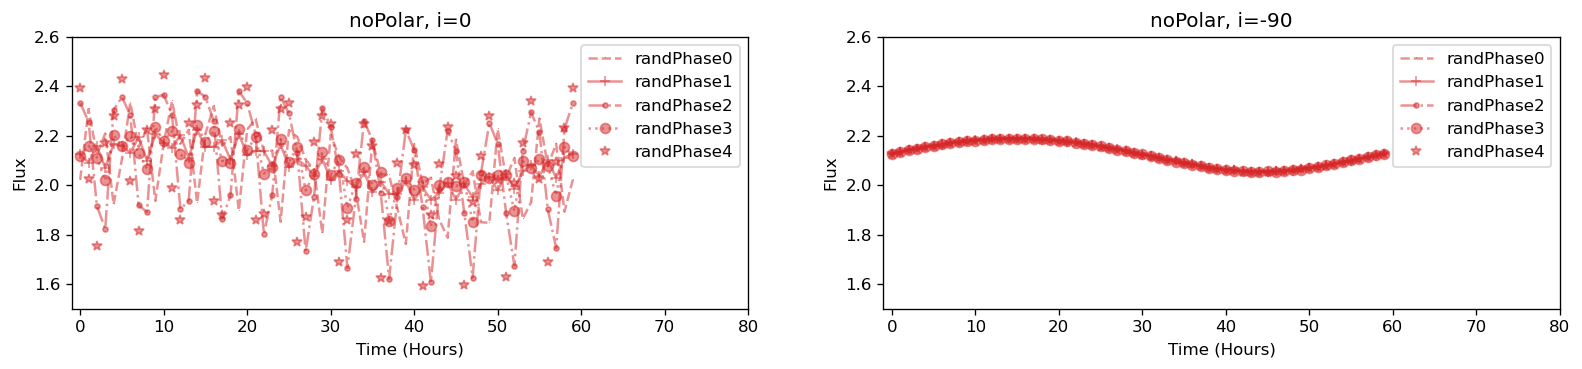

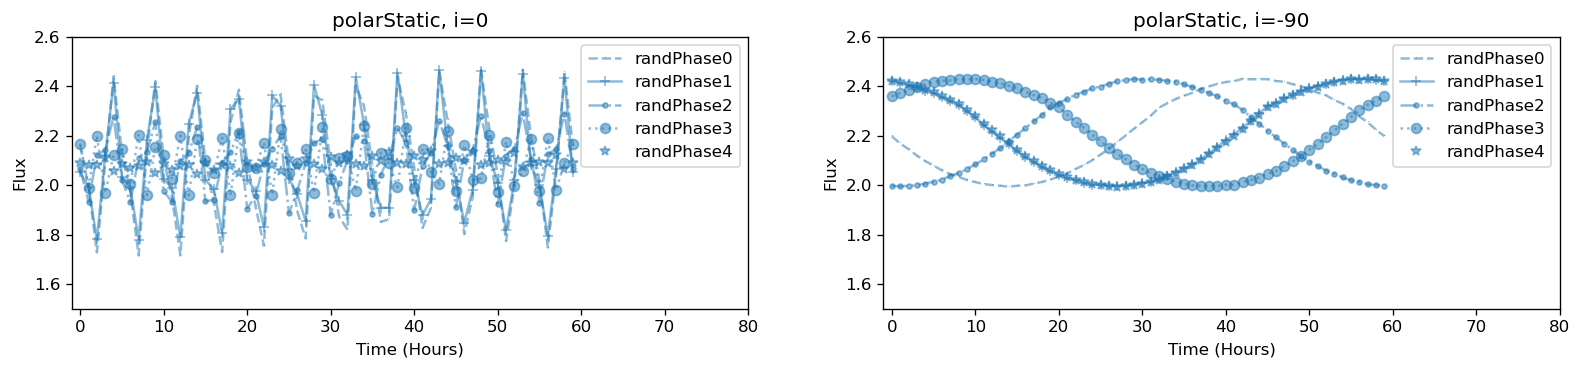

In [8]:
# ============================================================
# [[Plot]]
# Plot all norm_flux with time for each inclinations
# in each model classes
# ============================================================    
plt.close()
colorList = {'polarStatic':'tab:blue', 'noPolar':'tab:red', 'polarDynamic':'k', 'nothing':'tab:green'}
# markList4 = {'0':'*', '-30':'.', '-60':'x', '-90':'^'}
for model in modelclasses: 
    fig, axs = plt.subplots(1,2, dpi=120, figsize=(16,3))
    for i, iang in enumerate(['0', '-90']):
        for counter, productionKey in enumerate(production_keys):
            y_flux = fluxes[model][iang][counter]['norm']

            line, = axs[i].plot(time_array, y_flux, c=colorList[model],
                                ls=next(linestyleRandomList), marker=next(markerRandomList),
                             alpha=0.5, label=r'randPhase%i'%counter)
            
            axs[i].set_xlim(-1, 80), axs[i].set_ylim(1.5, 2.6)
            axs[i].set_xlabel('Time (Hours)'), axs[i].set_ylabel('Flux')
            axs[i].set_title(model+', i='+iang)
            axs[i].legend(loc='upper right')
        
    # These are in unitless percentages of the figure size. (0,0 is bottom left)
    # left, bottom, width, height = [0.675, 0.15, 0.38, 0.38]
    # subax1 = fig.add_axes([left, bottom, width, height])
    # subax1.imshow(images[model]['-50'][counter][5][0], cmap='inferno')
    # subax1.set_xticks([])
    # subax1.set_yticks([])

## Step 2: Generate Synthetic Spectra Cube with Sonora - Cloudy vs. Cloudless

#### 2A) [read, create, calculate, plot] Binning down Sonora Cloudless & Cloudy Model

In [9]:
# cloudlessPath ='~/Documents/GitHub/polar_vortice/data/spectras/[siUnit]bobcatCloudless_sp_t1200g1000nc_m0.00_co1.0_std.spec'
# cloudyPath = '~/Documents/GitHub/polar_vortice/data/spectras/[siUnit]diamondbackCloudy_sp_t1200g1000nc_m0.0_co1.0_std.spec'

cloudlessPath = '/Users/nguyendat/Documents/GitHub/polar_vortice/data/spectras/t1200g1000nc_m0.0_co1.0_std.spec'
# cloudlessPath = '/Users/nguyendat/Documents/GitHub/polar_vortice/data/spectras/t1200g1000f8_m0.0_co1.0_std.spec'
# cloudlessPath = '/Users/nguyendat/Documents/GitHub/polar_vortice/data/spectras/t1200g1000f4_m0.0_co1.0_std.spec'
# cloudlessPath = '/Users/nguyendat/Documents/GitHub/polar_vortice/data/spectras/t1200g1000f3_m0.0_co1.0_std.spec'

# cloudyPath = '/Users/nguyendat/Documents/GitHub/polar_vortice/data/spectras/t1200g1000f8_m0.0_co1.0_std.spec'
# cloudyPath = '/Users/nguyendat/Documents/GitHub/polar_vortice/data/spectras/t1200g1000f4_m0.0_co1.0_std.spec'
# cloudyPath = '/Users/nguyendat/Documents/GitHub/polar_vortice/data/spectras/t1200g1000f3_m0.0_co1.0_std.spec'
# cloudyPath = '/Users/nguyendat/Documents/GitHub/polar_vortice/data/spectras/t1200g1000f2_m0.0_co1.0_std.spec'
cloudyPath = '/Users/nguyendat/Documents/GitHub/polar_vortice/data/spectras/t1200g1000f1_m0.0_co1.0_std.spec'


cloudlessSpec = pd.read_csv(cloudlessPath, sep='\s+', names = ['wave', 'flux'], skiprows=3)
cloudlessSpec = cloudlessSpec.query(' 0.0 <= wave <= 15.09')
cloudlessSpec.sort_values('wave', inplace=True)

cloudySpec = pd.read_csv(cloudyPath, sep='\s+', names = ['wave', 'flux'], skiprows=3)
cloudySpec = cloudySpec.query(' 0.0 <= wave <= 15.09')
cloudySpec.sort_values('wave', inplace=True)

maxCloudless = cloudlessSpec.flux.max()
maxCloudy = cloudySpec.flux.max()
if maxCloudless > maxCloudy: 
    maxfluxValue = maxCloudless
else:
    maxfluxValue = maxCloudy

cloudlessSpec['norm'] = cloudlessSpec.flux / maxfluxValue
cloudySpec['norm'] = cloudySpec.flux / maxfluxValue

# set up color index center wavelength
lamJ, lamH = 1.10, 1.60
lamK = 2.20
lamContinuum = 1.275
lamwidth = 0.10

lamsilicate = [9.0, 9.6]
lamsilicateMean = np.mean(lamsilicate)
lamcont1, lamcont2 = [7.2, 7.7], [13.0, 14.0]
lamcont1Mean, lamcont2Mean = np.mean(lamcont1), np.mean(lamcont2)

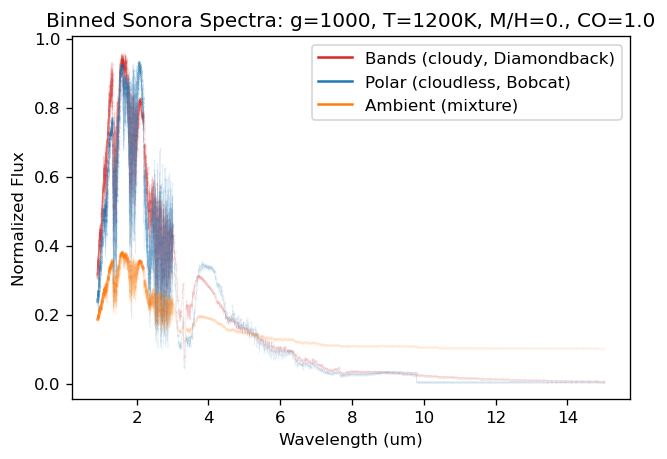

In [10]:
%matplotlib inline
# %matplotlib widget
# ================================================================================
# [[Plot]]
# Plot the binned flux, and output file for cloudy AND cloudless spectra
# idea: try searching a bin-reserving flux
# idea: try NIRSPEC resolution, R=2000
# ================================================================================
### Options
# save = True ## output spectra files
save = False
# ==== perform convolution of box-car smooth and plot spectras ===================
rebinning = False 
# rebinning = True

read = not rebinning ## reading existing, smoothed spectra
# ================================================================================
# Boxcar convolution for spectra binning
# ================================================================================
if rebinning:
    plt.close(), plt.figure(figsize=(10,5), dpi=120)
    # print(cloudySpec.norm.shape)
    # plt.plot(cloudySpec.wave, cloudySpec.norm)
    cloudy, cloudless = [], []
    binresolution = 2000
    binresolution = 50
    convolve_res = 50

    wavebin1 = convolve(cloudySpec.wave, Box1DKernel(convolve_res))[::binresolution]
    normbin1 = convolve(cloudySpec.norm, Box1DKernel(convolve_res))[::binresolution]
    # print(wavebin1.shape)

    wavebin2 = convolve(cloudlessSpec.wave, Box1DKernel(convolve_res))[::binresolution]
    normbin2 = convolve(cloudlessSpec.norm, Box1DKernel(convolve_res))[::binresolution]
    # print(wavebin2.shape)
    normbin2_interp = np.interp(x=wavebin1, xp=wavebin2, fp=normbin2)

    plt.plot(wavebin1, normbin1, marker='.', c='tab:red', label='cloudy', alpha=0.5, ms=0.5)
    plt.plot(wavebin1, normbin2_interp, marker='.', c='tab:blue', label='cloudless', alpha=0.5, ms=0.5)
    # plt.plot(wavebin1, 0.1 + 0.1*(normbin2_interp+normbin1)/2, ls='--', marker='', c='orange', label='averaged', alpha=0.17)

    R=1.5/np.diff(wavebin1).mean() 
    # print('R=lamda/d_lamda=', R)
    # center wavelength near J and H band
    # plt.axvline(lamJ-lamwidth, c='k', ls='--', lw=0.5), plt.axvline(lamJ+lamwidth, c='k', ls='--', lw=0.5)
    # plt.axvline(lamH-lamwidth, c='k', ls='-.', lw=0.5), plt.axvline(lamH+lamwidth, c='k', ls='-.', lw=0.5)
    # plt.axvline(lamContinuum-lamwidth/2, c='k', ls='-.', lw=0.5), plt.axvline(lamContinuum+lamwidth/2, c='k', ls='-.', lw=0.5)
    
    plt.xlim(0.90,2.390)
    # plt.xlim(4.0,15.090)
    plt.title('Binned Sonora Spectra: g=1000, T=1200K, M/H=0., CO=1.0')
    plt.xlabel('Wavelength (um)')
    plt.ylabel('Normalized Flux')
    plt.legend()
    
    # ================================================================================
    ### Output binned spectras into text files
    # ================================================================================

    pathCloudyOut = '~/Documents/GitHub/polar_vortice/data/spectras/binR=%i_diamondbackCloudy_sp_t1200g1000nc_m0.0_co1.0_std_0-15um.spec'%R
    cloudy = pd.DataFrame(np.transpose(np.array([wavebin1, normbin1])), columns=['wave','flux'])
    cloudy = cloudy.query('0.90 <= wave <= 15.09')
    cloudy.flux = cloudy.flux
    if save: cloudy.to_csv(pathCloudyOut, index=False)

    pathCloudlessOut = '~/Documents/GitHub/polar_vortice/data/spectras/binR=%i_bobcatCloudless_sp_t1200g1000nc_m0.00_co1.0_std_0-15um.spec'%R
    cloudless = pd.DataFrame(np.transpose(np.array([wavebin1, normbin2_interp])), columns=['wave','flux'])
    cloudless = cloudless.query('0.90 <= wave <= 15.09')
    cloudless.flux = cloudless.flux
    if save: cloudless.to_csv(pathCloudlessOut, index=False)

# ================================================================================
# read from existing saved spectras
# ================================================================================
if read:
    header = ['wave', 'flux']
    cloudy, cloudless = [], []
    # pathCloudyOutput = '~/Documents/GitHub/polar_vortice/data/spectras/binR=27_diamondbackCloudy_sp_t1200g1000nc_m0.0_co1.0_std.spec'
    pathCloudyOutput = '~/Documents/GitHub/polar_vortice/data/spectras/binR=1124_diamondbackCloudy_sp_t1200g1000nc_m0.0_co1.0_std_0-15um.spec'
    cloudy = pd.read_csv(pathCloudyOutput, names=header, skiprows=1)
    
    # pathCloudlessOutput = '~/Documents/GitHub/polar_vortice/data/spectras/binR=27_bobcatCloudless_sp_t1200g1000nc_m0.00_co1.0_std.spec'
    pathCloudlessOutput = '~/Documents/GitHub/polar_vortice/data/spectras/binR=1124_bobcatCloudless_sp_t1200g1000nc_m0.00_co1.0_std_0-15um.spec'
    cloudless = pd.read_csv(pathCloudlessOutput, names=header, skiprows=1)
    
    plt.close(), plt.figure(figsize=(6,4), dpi=120)
    # print(cloudy.flux.shape)
    
    bandspec = cloudy.sort_values(by='wave').flux.iloc[:-1]
    polarspec = cloudless.sort_values(by='wave').flux.iloc[:-1]
    basespec = 0.1 + 0.1*polarspec + 0.2*bandspec
    lam = cloudy.sort_values(by='wave').wave.iloc[:-1]
    
    plt.plot(lam, bandspec, ls='--', marker='.', c='tab:red', alpha=0.5, ms=0.1, lw=0.1)
    plt.plot(lam, polarspec, ls='--', marker='.', c='tab:blue', alpha=0.5, ms=0.1, lw=0.1)
    plt.plot(lam, basespec, ls='--', marker='.', c='tab:orange', alpha=0.4, ms=0.1, lw=0.1)
    
    # fake plot for better legend opacity 
    plt.plot([],[], c='tab:red', label='Bands (cloudy, Diamondback)')
    plt.plot([],[], c='tab:blue', label='Polar (cloudless, Bobcat)')
    plt.plot([],[], c='tab:orange', label='Ambient (mixture)')
             
    R=1.5/np.diff(cloudy.wave).mean() 
    # print('R=lamda/d_lamda=', R)
    # center wavelength near J and H band
#     plt.axvline(lamJ-lamwidth, c='k', ls='--', lw=0.5)
#     plt.axvline(lamJ+lamwidth, c='k', ls='--', lw=0.5)
    
#     plt.axvline(lamH-lamwidth, c='k', ls='--', lw=0.5)
#     plt.axvline(lamH+lamwidth, c='k', ls='--', lw=0.5)
    
#     plt.axvline(lamContinuum-lamwidth/2, c='k', ls='-.', lw=0.5)
#     plt.axvline(lamContinuum+lamwidth/2, c='k', ls='-.', lw=0.5)
    
    plt.title('Binned Sonora Spectra: g=1000, T=1200K, M/H=0., CO=1.0')
    plt.xlabel('Wavelength (um)')
    plt.ylabel('Normalized Flux')
    plt.legend()          

#### 2B) [read, create, calculate] Generate the spectral datacube

**Method of generate spectral cube:** 
- Obtain flux by feature-class type (`ambient`,`band`,`polar`): These types will be a function of:
    + Latitudinal distribution of each feature-class
    + and the inclination angle which affect the projected area of each feature-class
- Generate spectras by feature-class type (`ambient`,`band`,`polar`):
    + Use a constant 0.2 flux for `ambient`.
    + Use Sonora-Bobcat Cloudless for `polar`.
    + Use Sonora-Diamondback Cloudy for `band`.
- Final expression: `Total` = norm_mean( $\Sigma [$ $\text{Frac. area}(i) \times (1+\text{Flux} (i)) \times \text{Spectra} (i)]$ )

In [15]:
### outline the wavelength band to calculate color
Jband_index = np.where(np.logical_and((lamJ-lamwidth)<=lam, lam<=(lamJ+lamwidth)))[0].tolist()
Hband_index = np.where(np.logical_and((lamH-lamwidth)<=lam, lam<=(lamH+lamwidth)))[0].tolist()
Kband_index = np.where(np.logical_and((lamK-lamwidth)<=lam, lam<=(lamK+lamwidth)))[0].tolist()
continuum_index = np.where(np.logical_and((lamContinuum-lamwidth/2)<=lam, lam<=(lamContinuum+lamwidth/2)))[0].tolist()

### outline the wavelength band to calculate silicate index
# lamsilicate = [9.0, 9.6]
# lamcont1, lamcont2 = [7.2, 7.7], [13.0, 14.0]
sili_index = np.where(np.logical_and(lamsilicate[0]<=lam, lam<=lamsilicate[1]))[0].tolist()
continuum1_index = np.where(np.logical_and(lamcont1[0]<=lam, lam<=lamcont1[1]))[0].tolist()
continuum2_index = np.where(np.logical_and(lamcont2[0]<=lam, lam<=lamcont2[1]))[0].tolist()

In [53]:
# ================================================================================
# Define spectras of ambient (basespec), 
# band (bandspec) and polar region (polarspec).
# ================================================================================
#### Output options
save = False
# save = True
testPlot = True
# testPlot = False

bandspec = cloudy.flux.iloc[:-1]
polarspec = cloudless.flux.iloc[:-1]
# polarspec = cloudy.flux.iloc[:-1]
# bandspec = cloudless.flux.iloc[:-1]
basespec = 1.0 + 0.1*cloudless.flux.iloc[:-1]
lam = cloudy.wave.iloc[:-1]

# ================================================================================
# Spectra cube configs
# ================================================================================

spectral_cube = nested_dict()

colorList = {'polarStatic':'tab:blue', 'polarDynamic':'k', 'noPolar':'tab:red', 'nothing':'gray'}
aliasList = {'polarStatic':'Evolving Vortex', 'polarDynamic':'k', 'noPolar':'Stationary Vortex', 'nothing':'No Vortex'}

for counter in range(len(production_keys)):
    for i, model in enumerate(modelclasses):
        for iang in incli:
            ambflux = fluxes[model][iang][counter]['bytype']['amb']
            bandflux = fluxes[model][iang][counter]['bytype']['band']
            polflux = fluxes[model][iang][counter]['bytype']['pol']

            frac_amb = fluxes[model][iang][counter]['fraction']['amb']
            frac_band = fluxes[model][iang][counter]['fraction']['band']
            frac_pol = fluxes[model][iang][counter]['fraction']['pol']

            # prepare spectral cube
            spectra_array, JHcolor_array = [], []
            JKcolor_array = []
            continuum_array = []
            silicateIndex_array = []

            for i,t in enumerate(time_array): 
                # spectra_at_t = ambflux[i]*frac_amb*basespec + bandflux[i]*frac_band*bandspec + polflux[i]*frac_pol*polarspec
                spectra_at_t = ambflux[i]*basespec + bandflux[i]*bandspec + polflux[i]*polarspec

                jhcolor_at_t = np.sum(spectra_at_t.iloc[Jband_index]) - np.sum(spectra_at_t.iloc[Hband_index])
                jkcolor_at_t = np.sum(spectra_at_t.iloc[Jband_index]) - np.sum(spectra_at_t.iloc[Kband_index])
                # continuumRatio = jhcolor_at_t/np.mean(spectra_at_t.iloc[continuum_index])

                spectra_array.append(spectra_at_t)
                JHcolor_array.append(jhcolor_at_t)
                JKcolor_array.append(jkcolor_at_t)
                # continuum_array.append(continuumRatio)

                #### Calculate the silicate index
#                 sili_at_t = np.mean(spectra_at_t.iloc[sili_index])
#                 cont1_at_t = np.mean(spectra_at_t.iloc[continuum1_index])
#                 cont2_at_t = np.mean(spectra_at_t.iloc[continuum2_index])
#                 logY = log_interp1d((lamcont1Mean, lamcont2Mean), (cont1_at_t, cont2_at_t), kind='linear')
#                 siliIndex_at_t = sili_at_t / logY(lamsilicateMean)

#                 silicateIndex_array.append(siliIndex_at_t)

            spectral_cube[model][iang][counter]['spectra'] = spectra_array
            spectral_cube[model][iang][counter]['JH_color'] = JHcolor_array
            spectral_cube[model][iang][counter]['JK_color'] = JKcolor_array
            
            # spectral_cube[model][iang][counter]['continuumRatio'] = continuum_array
            # spectral_cube[model][iang][counter]['silicateIndex'] = silicateIndex_array

dict_keys([0, 1, 2, 3, 4, 'JK_color'])

#### 2B1.5) subroutine - create third-case of modelClass: 'nothing' - spectral_cube

In [57]:
# =============================================================================
#### 2B1.5) subroutine - create third-case of modelClass: 'nothing': 
# polar region doesn't change in brightness just like 'noPolar'
# but doesn't have different cloud signature in polar region and equator, 
# unlike both 'noPolar' and 'polarStatic'.
# =============================================================================
newmodel = 'nothing'
basemodel = 'noPolar'
basespec2 = 1.2 + 0.2*cloudy.flux.iloc[:-1] + 0.2*cloudless.flux.iloc[:-1]

for counter in range(len(production_keys)):
    for iang in incli:
        ambflux = fluxes[basemodel][iang][counter]['bytype']['amb']
        bandflux = fluxes[basemodel][iang][counter]['bytype']['band']
        polflux = fluxes[basemodel][iang][counter]['bytype']['pol']

        frac_amb = fluxes[basemodel][iang][counter]['fraction']['amb']
        frac_band = fluxes[basemodel][iang][counter]['fraction']['band']
        frac_pol = fluxes[basemodel][iang][counter]['fraction']['pol']

        # prepare spectral cube
        spectra_array, JHcolor_array = [], []
        JKcolor_array = []
        continuum_array = []
        silicateIndex_array = []

        for i,t in enumerate(time_array): 
            # spectra_at_t = ambflux[i]*frac_amb*basespec + bandflux[i]*frac_band*bandspec + polflux[i]*frac_pol*basespec2
            spectra_at_t = ambflux[i]*basespec2 + bandflux[i]*bandspec + polflux[i]*basespec2
            jhcolor_at_t = np.sum(spectra_at_t.iloc[Jband_index]) - np.sum(spectra_at_t.iloc[Hband_index])
            jkcolor_at_t = np.sum(spectra_at_t.iloc[Jband_index]) - np.sum(spectra_at_t.iloc[Kband_index])
            # continuumRatio = jhcolor_at_t/np.mean(spectra_at_t.iloc[continuum_index])

            spectra_array.append(spectra_at_t)
            JHcolor_array.append(jhcolor_at_t)
            JKcolor_array.append(jkcolor_at_t)
            # continuum_array.append(continuumRatio)

            #### Calculate the silicate index
#             sili_at_t = np.mean(spectra_at_t.iloc[sili_index])
#             cont1_at_t = np.mean(spectra_at_t.iloc[continuum1_index])
#             cont2_at_t = np.mean(spectra_at_t.iloc[continuum2_index])
#             logY = log_interp1d((lamcont1Mean, lamcont2Mean), (cont1_at_t, cont2_at_t), kind='linear')
#             siliIndex_at_t = sili_at_t / logY(lamsilicateMean)

#             silicateIndex_array.append(siliIndex_at_t)

        spectral_cube[newmodel][iang][counter]['spectra'] = spectra_array
        spectral_cube[newmodel][iang][counter]['JH_color'] = JHcolor_array
        spectral_cube[newmodel][iang][counter]['JK_color'] = JKcolor_array
        # spectral_cube[model][iang][counter]['continuumRatio'] = continuum_array
        # spectral_cube[newmodel][iang][counter]['silicateIndex'] = silicateIndex_array

In [60]:
### double check 
for model in ['noPolar', 'polarStatic', 'nothing']:
    print(model, ':', spectral_cube[model]['0'].keys())

noPolar : dict_keys([0, 1, 2, 3, 4])
polarStatic : dict_keys([0, 1, 2, 3, 4])
nothing : dict_keys([0, 1, 2, 3, 4])


In [28]:
# save = False
# # save = True

# %matplotlib inline

# fig, axs = plt.subplots(2,2, figsize=(13, 7), dpi=120)
# ### axs[0,0]: Plot 1: photometry polarStatic
# colorList = {'polarStatic':'tab:blue', 'polarDynamic':'k', 'noPolar':'tab:red'}
# markList4 = {'0':'*', '-30':'.', '-60':'x', '-90':'^'}
# model = 'polarStatic'
# for iang in incli:
#     iNum = int(iang) + 90
#     y_flux = fluxes[model][iang]['norm']
#     if iang == '-90' or iang =='0':
#         line, = axs[0,0].plot(time_array, y_flux, c=colorList[model],ls='-', 
#                          marker=markList4[iang], alpha=1, lw=1.5, label=r'i= %i$^\circ$'%iNum, ms=8)
#     elif iang == '-30' or iang == '-60':
#         line, = axs[0,0].plot(time_array, y_flux, c=colorList[model],ls=next(linestyleRandomList), 
#                          marker=markList4[iang], alpha=0.6, label=r'i= %i$^\circ$'%iNum, ms=8)
#     axs[0,0].set_xlim(-1, 61), axs[0,0].set_xlabel('Time (Hours)'), axs[0,0].set_ylabel('Flux')
#     # axs[0,0].set_title(model)
#     axs[0,0].legend(loc='lower left')
    
# # axs[0,0].text(15, 0.30, 'Scenario 1:\n"Polar-static"', fontsize=12, weight='bold')
# # axs[0,0].text(31, 0.41, r'Flux-vs-time with inclination $i$', fontsize=12)
    
# ### axs[1,0]: Plot 3: photometry noPolar
# markList4 = {'0':'*', '-30':'.', '-60':'x', '-90':'^'}
# model = 'noPolar'
# for iang in incli:
#     iNum = int(iang) + 90
#     y_flux = fluxes[model][iang]['norm']
#     if iang == '-90' or iang =='0':
#         line, = axs[1,0].plot(time_array, y_flux, c=colorList[model],ls='-', 
#                          marker=markList4[iang], alpha=1, lw=1.5, label=r'i= %s$^\circ$'%iNum, ms=8)
#     elif iang == '-30' or iang == '-60':
#         line, = axs[1,0].plot(time_array, y_flux, c=colorList[model],ls=next(linestyleRandomList), 
#                          marker=markList4[iang], alpha=0.6, label=r'i= %i$^\circ$'%iNum, ms=8)
#     axs[1,0].set_xlim(-1, 61), axs[1,0].set_xlabel('Time (Hours)'), axs[1,0].set_ylabel('Flux')
#     # axs[1,0].set_title(model)
#     axs[1,0].legend(loc='lower left')
    
# # axs[1,0].text(15, 0.31, 'Scenario 2:\n"No-polar"', fontsize=12, weight='bold')
# # axs[1,0].text(31, 0.40, r'Flux-vs-time with inclination $i$', fontsize=12)

# ### axs[0,1]: Plot 2: spectra polarStatic
# model = 'polarStatic'
# iang = '-60'
# colorLists = ['tab:blue', 'darkblue']
# lineLists = ['','-']
# for i,t in enumerate([0,15]):
#     specnum = spectral_cube[model][iang]['spectra'][t]
#     axs[0,1].plot(lam, specnum, ls=lineLists[i], lw=0.5, marker='+', ms=0.5, c=colorLists[i], alpha=0.25)
# # axs[0,1].set_ylim(0.0, 0.42)
# axs[0,1].set_xlim(0.9, 2.30)
# axs[0,1].set_xlabel(r'Wavelength ($\mu$m)')
# axs[0,1].set_ylabel('Intensity')
    
# # axs[0,1].text(1.4, 0.275, 'Scenario 1:\n"Polar-static"', fontsize=12, weight='bold')
# # axs[0,1].text(0.9, 0.38, 'All spectra from t=0-60 hr for $i=-60^\circ$', fontsize=12)

# ### axs[1,0]: Plot 4: spectra noPolar
# model = 'noPolar'
# iang = '-60'
# colorLists = ['tab:red', 'darkred']
# lineLists = ['','-']
# for i,t in enumerate([0,15]):
#     specnum = spectral_cube[model][iang]['spectra'][t]
#     axs[1,1].plot(lam, specnum, ls=lineLists[i], lw=0.5, marker='+', ms=0.5, c=colorLists[i], alpha=0.25)
# # axs[1,1].set_ylim(0.0, 0.42)
# axs[1,1].set_xlim(0.9, 2.30)
# axs[1,1].set_xlabel(r'Wavelength ($\mu$m)')
# axs[1,1].set_ylabel('Intensity')

# # axs[1,1].text(1.4, 0.275, 'Scenario 2:\n"no-Polar"', fontsize=12, weight='bold')
# # axs[1,1].text(0.9, 0.38, 'All spectra from t=0-60 hr for $i=-60^\circ$', fontsize=12)

# # =========== subaxes ===========================

# # subax1: display polarStatic image
# left, bottom, width, height = [0.84, 0.79, 0.2, 0.2]
# subax1 = fig.add_axes([left, bottom, width, height])
# subax1.imshow(images['polarStatic']['-50'][5][0], cmap='inferno')
# subax1.set_xticks([])
# subax1.set_yticks([])

# # subax2: display noPolar image
# left, bottom, width, height = [0.84, 0.30, 0.2, 0.2]
# subax2 = fig.add_axes([left, bottom, width, height])
# subax2.imshow(images['noPolar']['-50'][5][0], cmap='inferno')
# subax2.set_xticks([])
# subax2.set_yticks([])

# # ending options
# plt.tight_layout()

# if save:
#     plotOut = plotPath + '/2x2_photometry_and_spectra_ByScenario'
#     plt.savefig(plotOut+'.pdf', dpi=300, format='pdf', bbox_inches = 'tight')
#     plt.savefig(plotOut+'.png', dpi=300, format='png', bbox_inches = 'tight')

In [29]:
# # ================================================================================
# # [[Plot]]
# # Spectra cube test plots for two inclination, by model class 
# # 1) spectras at all timestamps, two model classes: blue and red
# # 2) j-h color evolution by time, two model classes: blue and red
# # ================================================================================
# # save = True
# save = False

# plt.close()
# plt.rcParams.update({'font.size': 12})
# for iang in ['0', '-50','-90']:
#     iNum = int(iang)+90
    
#     f, axs = plt.subplots(1, 3, figsize=(15,4), dpi=120, gridspec_kw={'width_ratios':[3, 3, 1]})
#     cadence = (t1-t0)/no_frame
#     # f.suptitle('Spectra-time-series & J-H color')
#     # plt.tight_layout()
#     axs[0].set_title(r'Spectra(t$_{max}$) / Spectra(t$_{min}$)')
#     axs[1].set_title('[J-H] color over time, ' + r'$i=%i^\circ$'%iNum)
#     axs[2].set_title(r'$i=%i^\circ$'%iNum)
    
#     offset = [0., 0.0]
#     ax2LinestyleList = ['-.', '--']
#     ax2MarketList = ['+', '.']
    
#     for i, model in enumerate(modelclasses):
#         linestyle = next(linestyleRandomList)
    
#         t_fluxmin = fluxes[model][iang]['norm'].argmin()
#         t_fluxmax = fluxes[model][iang]['norm'].argmax()
#         spec_fluxmin = spectral_cube[model][iang]['spectra'][t_fluxmin]
#         spec_fluxmax = spectral_cube[model][iang]['spectra'][t_fluxmax]
#         spec_ratio = spec_fluxmax / spec_fluxmin
#         axs[0].plot(lam, spec_ratio + offset[i], ls='-', lw=0.1, marker='.', ms=0.5, c=colorList[model], alpha=1)
        
#         axs[0].plot([], c=colorList[model], label=aliasList[model])
#         axs[0].legend(fontsize=10)
#         axs[0].set_xlabel('Wavelength (um)')
#         axs[0].set_ylabel('Flux ratio')
#         axs[0].set_xlim(0.9, 2.30)
#         # axs[0].axhline(offset[i], ls='--', lw=0.2, c='k')

#         colorArray = spectral_cube[model][iang]['JH_color']
#         meanColor = np.mean(colorArray)
        
#         axs[1].plot([t_fluxmin, t_fluxmax], [colorArray[t_fluxmin], colorArray[t_fluxmax]], ls='', marker='^', c=colorList[model], ms=10)
#         axs[1].plot(time_array, colorArray, c=colorList[model], ls=ax2LinestyleList[i], lw=1, 
#                     marker=ax2MarketList[i], ms=6, label=aliasList[model]+': [J-H]=%.2f'%meanColor)
#         # axs[1].plot(30, meanColor, ls='', marker='', c=colorList[model], ms=5)
        
#         axs[1].legend(fontsize=10)
#         axs[1].set_ylabel('[J-H color]')
#         axs[1].set_xlabel('Time (hour)')
        
#         axs[2].imshow(specmasks[model][iang][0], cmap='inferno', vmax=0.85, vmin=0.)
#         axs[2].set_xticks([]), axs[2].set_yticks([])
        
#     if save:
#         plotOut = plotPath + '/1x3_spectraJHColorEvolution_i=%s'%iang
#         plt.savefig(plotOut+'.pdf', dpi=300, format='pdf', bbox_inches = 'tight')
#         plt.savefig(plotOut+'.png', dpi=300, format='png', bbox_inches = 'tight')

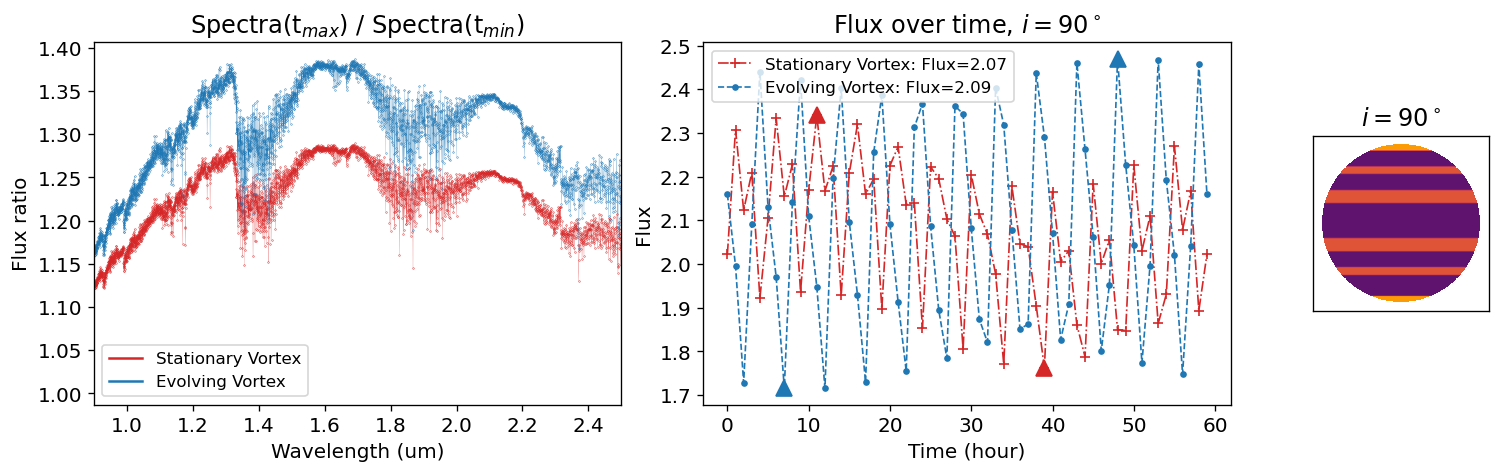

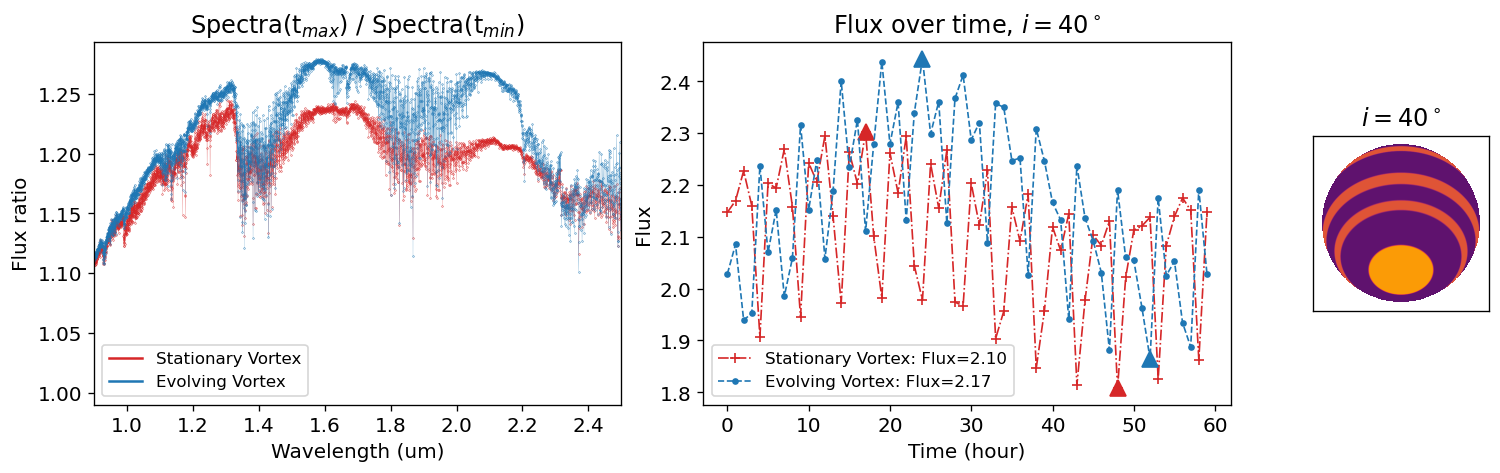

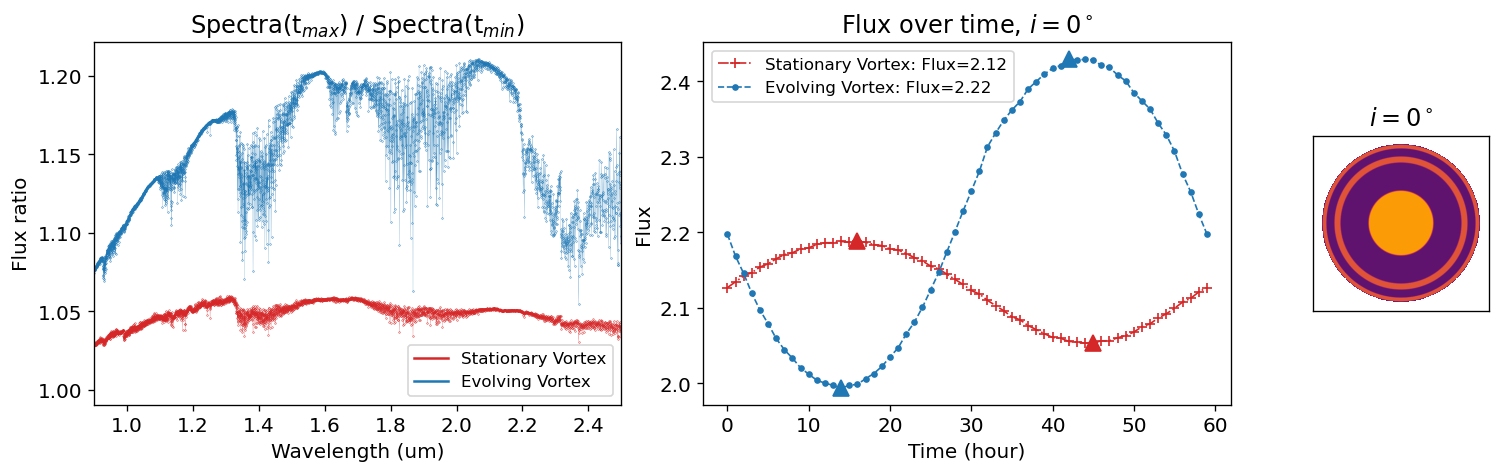

In [23]:
# ================================================================================
# [[Plot]]
# Spectra cube test plots for two inclination, by model class 
# 1) spectras at all timestamps, two model classes: blue and red
# 2) flux evolution by time, two model classes: blue and red
# ================================================================================
# save = True
save = False

plt.close()
plt.rcParams.update({'font.size': 12})
for iang in ['0', '-50','-90']:
    iNum = int(iang)+90
    
    f, axs = plt.subplots(1, 3, figsize=(15,4), dpi=120, gridspec_kw={'width_ratios':[3, 3, 1]})
    cadence = (t1-t0)/no_frame
    # f.suptitle('Spectra-time-series & J-H color')
    # plt.tight_layout()
    axs[0].set_title(r'Spectra(t$_{max}$) / Spectra(t$_{min}$)')
    axs[1].set_title('Flux over time, ' + r'$i=%i^\circ$'%iNum)
    axs[2].set_title(r'$i=%i^\circ$'%iNum)
    
    offset = [0., 0.0]
    ax2LinestyleList = ['-.', '--']
    ax2MarketList = ['+', '.']
    
    for i, model in enumerate(modelclasses):
        linestyle = next(linestyleRandomList)
    
        t_fluxmin = fluxes[model][iang]['norm'].argmin()
        t_fluxmax = fluxes[model][iang]['norm'].argmax()
        spec_fluxmin = spectral_cube[model][iang]['spectra'][t_fluxmin]
        spec_fluxmax = spectral_cube[model][iang]['spectra'][t_fluxmax]
        spec_ratio = spec_fluxmax / spec_fluxmin
        axs[0].plot(lam, spec_ratio + offset[i], ls='-', lw=0.1, marker='.', ms=0.5, c=colorList[model], alpha=1)
        
        axs[0].plot([], c=colorList[model], label=aliasList[model])
        axs[0].legend(fontsize=10)
        axs[0].set_xlabel('Wavelength (um)')
        axs[0].set_ylabel('Flux ratio')
        axs[0].set_xlim(0.9, 2.50)
        # axs[0].axhline(offset[i], ls='--', lw=0.2, c='k')

        fluxArray = fluxes[model][iang]['norm']
        meanFlux = np.mean(fluxArray)
        
        axs[1].plot([t_fluxmin, t_fluxmax], [fluxArray[t_fluxmin], fluxArray[t_fluxmax]], ls='', marker='^', c=colorList[model], ms=10)
        axs[1].plot(time_array, fluxArray, c=colorList[model], ls=ax2LinestyleList[i], lw=1, 
                    marker=ax2MarketList[i], ms=6, label=aliasList[model]+': Flux=%.2f'%meanFlux)
        # axs[1].plot(30, meanColor, ls='', marker='', c=colorList[model], ms=5)
        
        axs[1].legend(fontsize=10)
        axs[1].set_ylabel('Flux')
        axs[1].set_xlabel('Time (hour)')
        
        axs[2].imshow(specmasks[model][iang][0], cmap='inferno', vmax=0.85, vmin=0.)
        axs[2].set_xticks([]), axs[2].set_yticks([])
        
    if save:
        plotOut = plotPath + '/1x3_spectraFluxEvolution_i=%s'%iang
        plt.savefig(plotOut+'.pdf', dpi=300, format='pdf', bbox_inches = 'tight')
        plt.savefig(plotOut+'.png', dpi=300, format='png', bbox_inches = 'tight')

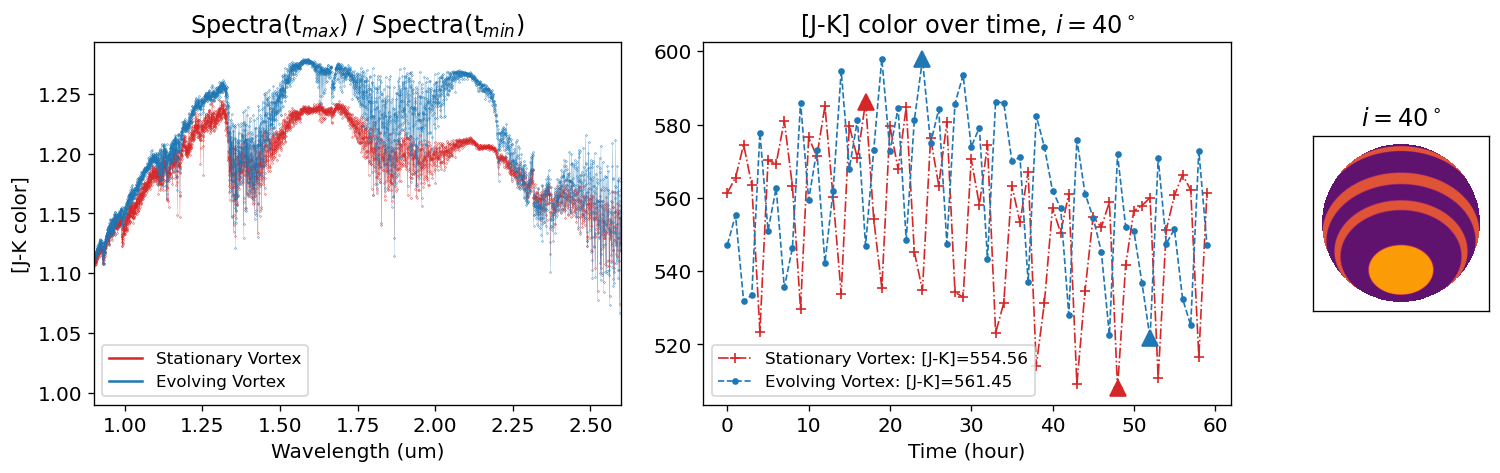

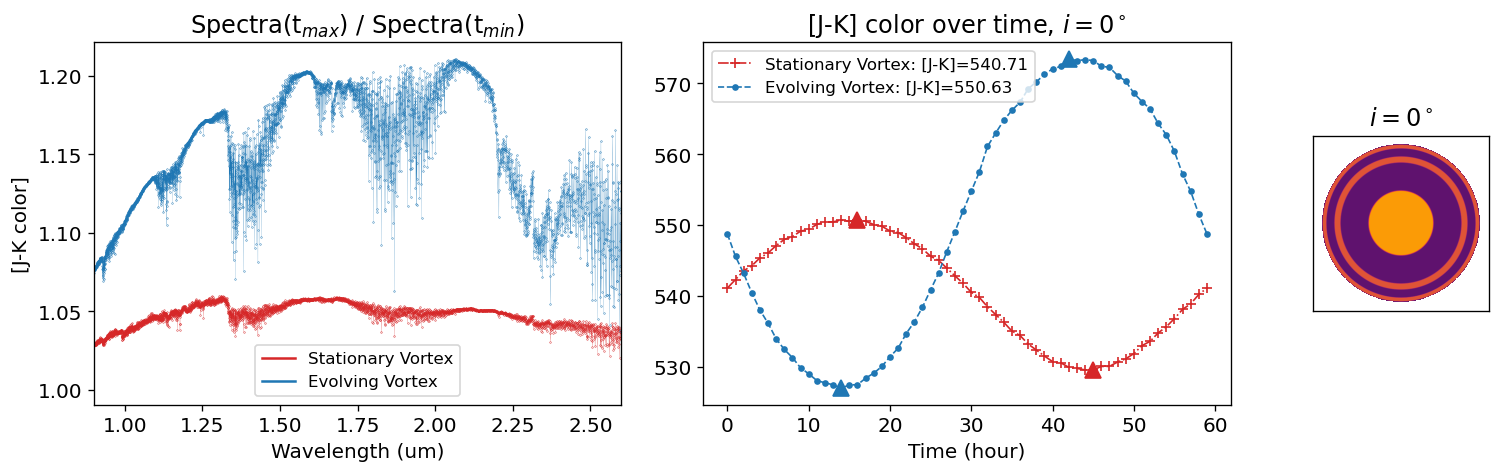

In [24]:
# ================================================================================
# [[Plot]]
# Spectra cube test plots for two inclination, by model class 
# 1) spectras at all timestamps, two model classes: blue and red
# 2) j-h color evolution by time, two model classes: blue and red
# ================================================================================
save = False
# save = True

plt.close()
for iang in ['-50','-90']:
    iNum = int(iang)+90
    
    f, axs = plt.subplots(1, 3, figsize=(15,4), dpi=120, gridspec_kw={'width_ratios':[3, 3, 1]})
    cadence = (t1-t0)/no_frame
    # f.suptitle('Spectra-time-series & J-Ks color')
    
    axs[0].set_title(r'Spectra(t$_{max}$) / Spectra(t$_{min}$)')
    axs[1].set_title('[J-K] color over time, ' + r'$i=%i^\circ$'%iNum)
    axs[2].set_title(r'$i=%i^\circ$'%iNum)
    
    offset = [0., 0.0]
    ax2LinestyleList = ['-.', '--']
    ax2MarketList = ['+', '.']
    
    for i, model in enumerate(modelclasses):
        linestyle = next(linestyleRandomList)
    
        t_fluxmin = fluxes[model][iang]['norm'].argmin()
        t_fluxmax = fluxes[model][iang]['norm'].argmax()
        spec_fluxmin = spectral_cube[model][iang]['spectra'][t_fluxmin]
        spec_fluxmax = spectral_cube[model][iang]['spectra'][t_fluxmax]
        spec_ratio = spec_fluxmax / spec_fluxmin
        axs[0].plot(lam, spec_ratio + offset[i], ls='-', lw=0.1, marker='.', ms=0.5, c=colorList[model], alpha=1)
        
        axs[0].plot([], c=colorList[model], label=aliasList[model])
        axs[0].legend(fontsize=10)
        axs[0].set_xlabel('Wavelength (um)')
        axs[0].set_ylabel('Intensity')
        axs[0].set_xlim(0.9, 2.6)
        # axs[0].axhline(offset[i], ls='--', lw=0.2, c='k')

        colorArray = spectral_cube[model][iang]['JK_color']
        meanColor = np.mean(colorArray)
        
        axs[1].plot([t_fluxmin, t_fluxmax], [colorArray[t_fluxmin], colorArray[t_fluxmax]], ls='', marker='^', c=colorList[model], ms=10)
        axs[1].plot(time_array, colorArray, c=colorList[model], ls=ax2LinestyleList[i], lw=1, 
                    marker=ax2MarketList[i], ms=6, label=aliasList[model]+': [J-K]=%.2f'%meanColor)
        axs[1].legend(fontsize=10)
        axs[0].set_ylabel('[J-K color]')
        axs[1].set_xlabel('Time (hour)')
        
        axs[2].imshow(specmasks[model][iang][0], cmap='inferno', vmax=0.85, vmin=0.)
        axs[2].set_xticks([]), axs[2].set_yticks([])
        
    if save:
        plotOut = plotPath + '/1x3_spectraJKColorEvolution_i=%s'%iang
        plt.savefig(plotOut+'.pdf', dpi=300, format='pdf', bbox_inches = 'tight')
        plt.savefig(plotOut+'.png', dpi=300, format='png', bbox_inches = 'tight')

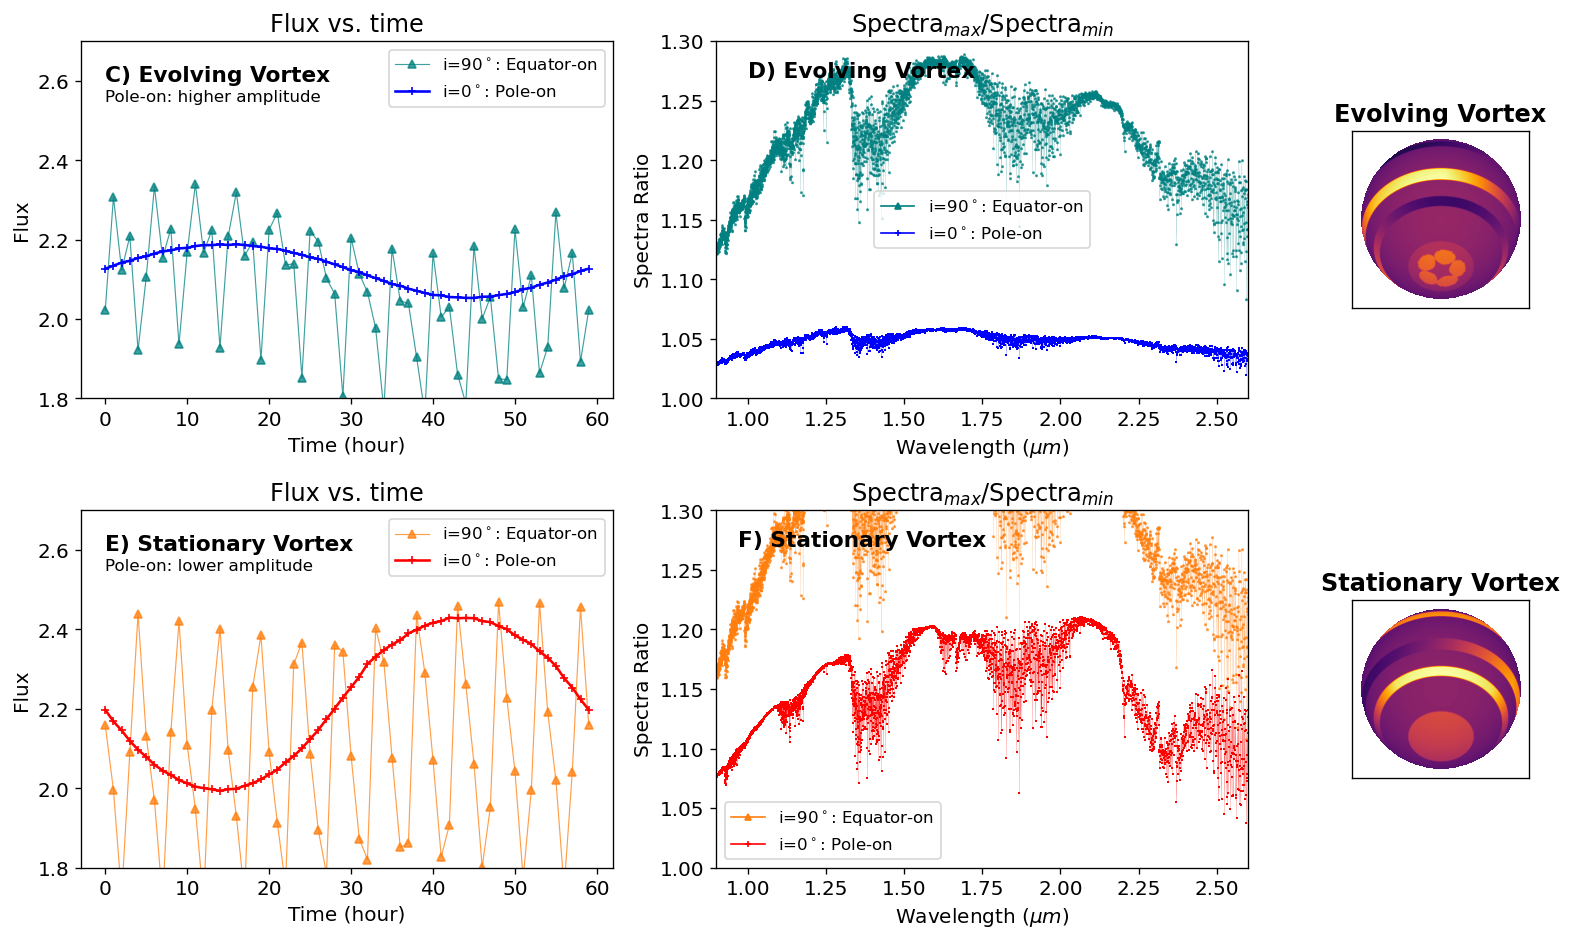

In [25]:
# # ================================================================================
# # [[Plot]]
# # Spectra cube test plots for two inclination, by model class 
# # 1) spectras at all timestamps, two model classes: blue and red
# # 2) flux evolution by time, two model classes: blue and red
# # ================================================================================
# # save = True
# save = False

# plt.close()
# plt.rcParams.update({'font.size': 12})

# f, axs = plt.subplots(2, 3, figsize=(13,8), dpi=120, gridspec_kw={'width_ratios':[3, 3, 1]})
# incliMarketList = ['^', '+', '.']
# lwList = [0.7, 1.55, 2.3]
# lsList = ['-', '-', '-']
# alphaList = [0.75, 1., 1.]
# colorsList = [['teal', 'blue', 'darkblue'], ['tab:orange', 'red', 'darkred'], ]
# # colorsList = [['teal', 'darkblue'], ['tab:orange', 'darkred'], ]
# labelOnList = {0: 'Pole-on', 90: 'Equator-on'}

# for i, model in enumerate(modelclasses):
#     # for n, iang in enumerate(['0', '-50','-90']):
#     for n, iang in enumerate(['0', '-90']):
#         iNum = int(iang)+90
        
#         ### flux plots
#         fluxArray = fluxes[model][iang]['norm']
#         axs[i,0].plot(time_array, fluxArray, c=colorsList[i][n], 
#                       ls=lsList[n], lw=lwList[n], marker=incliMarketList[n], 
#                       ms=5, label='i=%i$^\circ$'%iNum+': '+labelOnList[iNum], alpha=alphaList[n])
        
#         ### spectra plots
#         t_fluxmin = fluxes[model][iang]['norm'].argmin()
#         t_fluxmax = fluxes[model][iang]['norm'].argmax()
#         spec_fluxmin = spectral_cube[model][iang]['spectra'][t_fluxmin]
#         spec_fluxmax = spectral_cube[model][iang]['spectra'][t_fluxmax]
#         spec_ratio = spec_fluxmax / spec_fluxmin
#         axs[i,1].plot(lam, spec_ratio, ls='-', lw=0.1, 
#                       marker=incliMarketList[n], ms=1, c=colorsList[i][n], alpha=alphaList[n])
#         axs[i,1].plot([], [], ls='-', marker=incliMarketList[n], c=colorsList[i][n], ms=4, lw=1
#                       ,label='i=%i$^\circ$'%iNum+': '+labelOnList[iNum])
    
#     axs[i,0].legend(fontsize=10)
#     axs[i,0].set_ylabel('Flux')
#     axs[i,0].set_xlabel('Time (hour)')
#     axs[i,0].legend(fontsize=10)
#     axs[i,0].set_ylim(1.8, 2.7)
    
#     axs[i,1].legend(fontsize=10)
#     axs[i,1].set_xlim(0.90, 2.60)
#     axs[i,1].set_ylim(1.0, 1.30)
#     axs[i,1].set_ylabel('Spectra Ratio')
#     axs[i,1].set_xlabel(r'Wavelength ($\mu m$)')

#     axs[i,1].set_title(r'Spectra$_{max}$/Spectra$_{min}$')
#     axs[i,0].set_title(r'Flux vs. time')

# axs[0,0].text(0, 2.6, 'C) Evolving Vortex', fontsize=13, weight='bold')
# axs[0,0].text(0, 2.55, 'Pole-on: higher amplitude', fontsize=10)
# axs[1,0].text(0, 2.6, 'E) Stationary Vortex', fontsize=13, weight='bold')
# axs[1,0].text(0, 2.55, 'Pole-on: lower amplitude', fontsize=10)

# axs[0,1].text(1.0, 1.27, 'D) Evolving Vortex', fontsize=13, weight='bold')
# # axs[0,1].text(1.0, 1.2, 'Pole-on: higher ', fontsize=10)
# axs[1,1].text(0.97, 1.27, 'F) Stationary Vortex', fontsize=13, weight='bold')
# # axs[1,1].text(25, 1.85, 'Pole-on: lower amplitude', fontsize=12)

# ### imshow
# # axs[0,2].axis('off')
# axs[0,2].imshow(images['polarStatic']['-50'][5][0], cmap='inferno')
# axs[0,2].set_title('Evolving Vortex', weight='bold')
# axs[0,2].set_xticks([])
# axs[0,2].set_yticks([])

# # axs[1,2].axis('off')
# axs[1,2].set_title('Stationary Vortex', weight='bold')
# axs[1,2].imshow(images['noPolar']['-50'][10][0], cmap='inferno')
# axs[1,2].set_xticks([])
# axs[1,2].set_yticks([])

# plt.tight_layout() 

# if save:
#     plotOut = plotPath + '/2x2_photSpecEvolution'
#     plt.savefig(plotOut+'.pdf', dpi=300, format='pdf', bbox_inches = 'tight')
#     plt.savefig(plotOut+'.png', dpi=300, format='png', bbox_inches = 'tight')

#### 2E) [read, create, calculate, plot] Calculate time-averaged 'Amplitudes', as function of inclination for model class

**Definition of variation amplitude:** $\text{Amp}(x) = (\text{max}(x) - \text{min}(x))/2$

In [66]:
# ================================================================================
# [[Plot]]
# Quantify the variability amplitudes as a function of inclination
# by model class
# (1) J-H color
# (2) [J-H color]/[continuum]
# (3) J-Ks color
# ================================================================================
%matplotlib inline
amplitudes = nested_dict()

for counter in range(len(production_keys)):
    for model in modelclasses:
        # empty arrays
        emp1, emp2, emp3, emp4 = [], [], [], []
        emp5, emp6 = [], []
        # print(model)
        for iang in incli:

            colorArrayJH = np.array(spectral_cube[model][iang][counter]['JH_color'])
            colorArrayJK = np.array(spectral_cube[model][iang][counter]['JK_color'])
            ampColorJH = colorArrayJH.mean()
            ampColorJK = colorArrayJK.mean()

            # silicateArray = np.array(spectral_cube[model][iang][counter]['silicateIndex'])
            # continuumArray = np.array(spectral_cube[model][iang][counter]['continuumRatio'])

            #### amplitudes by taking middle value
            # ampColorJH = (colorArrayJH.max()-colorArrayJH.min())/2 
            # ampColorJK = (colorArrayJK.max()-colorArrayJK.min())/2
            # ampContinuumRatio = (continuumArray.max()-continuumArray.min())/2
            # ampSilicateIndex = (silicateArray.max()-silicateArray.min())/2

            #### amplitudes by taking time-averaged value
            # ampContinuumRatio = abs(continuumArray.max()-continuumArray.min())
            # ampSilicateIndex = silicateArray.mean()

            ampFlux = (np.array(fluxes[model][iang][counter]['norm']).max() 
                - np.array(fluxes[model][iang][counter]['norm']).min())/2

            t_fluxmin = fluxes[model][iang][counter]['norm'].argmin()
            t_fluxmax = fluxes[model][iang][counter]['norm'].argmax()
            spec_fluxmin = spectral_cube[model][iang][counter]['spectra'][t_fluxmin]
            spec_fluxmax = spectral_cube[model][iang][counter]['spectra'][t_fluxmax]
            ampSpecRatio = np.array(spec_fluxmax / spec_fluxmin).mean()

            ### summing through time
            # ampColorJH = colorArrayJH.sum()
            # ampColorJK = colorArrayJK.sum()
            # ampContinuumRatio = continuumArray.sum()

            emp1.append([int(iang), ampColorJH])
            # emp2.append([int(iang), ampContinuumRatio]) 
            emp3.append([int(iang), ampColorJK])
            # emp4.append([int(iang), ampSilicateIndex])

            emp5.append([int(iang), ampFlux])
            emp6.append([int(iang), ampSpecRatio])

        amplitudes[model][counter]['JH_color'] = np.array(emp1)
        # amplitudes[model]['continuumRatio'] = np.array(emp2)
        amplitudes[model][counter]['JK_color'] = np.array(emp3)
        # amplitudes[model]['silicateIndex'] = np.array(emp4)
        amplitudes[model][counter]['flux'] = np.array(emp5)
        amplitudes[model][counter]['specRatio'] = np.array(emp6)

#### 2E1.5) subroutine for third modelclass: 'nothing' - amplitudes

In [77]:
#### 2E2) subroutine - create third-case of modelClass: 'nothing': 

newmodel = 'nothing' # go into spectral_cube + amplitudes
basemodel = 'noPolar' # go into fluxes
for counter in range(len(production_keys)):
    # empty arrays
    emp1, emp2, emp3, emp4 = [], [], [], []
    emp5, emp6 = [], []
    # print(model)
    for iang in incli:
        continuumArray = np.array(spectral_cube[newmodel][iang][counter]['continuumRatio'])
        colorArrayJH = np.array(spectral_cube[newmodel][iang][counter]['JH_color'])
        colorArrayJK = np.array(spectral_cube[newmodel][iang][counter]['JK_color'])
        silicateArray = np.array(spectral_cube[newmodel][iang][counter]['silicateIndex'])

        #### amplitudes by taking time-averaged value
        ampColorJH = colorArrayJH.mean()
        ampColorJK = colorArrayJK.mean()
        # ampContinuumRatio = abs(continuumArray.max()-continuumArray.min())
        # ampSilicateIndex = silicateArray.mean()
        ampFlux = (np.array(fluxes[basemodel][iang][counter]['norm']).max() 
            - np.array(fluxes[basemodel][iang][counter]['norm']).min())/2

        t_fluxmin = fluxes[basemodel][iang][counter]['norm'].argmin()
        t_fluxmax = fluxes[basemodel][iang][counter]['norm'].argmax()
        spec_fluxmin = spectral_cube[newmodel][iang][counter]['spectra'][t_fluxmin]
        spec_fluxmax = spectral_cube[newmodel][iang][counter]['spectra'][t_fluxmax]
        ampSpecRatio = np.array(spec_fluxmax / spec_fluxmin).mean()

        emp1.append([int(iang), ampColorJH])
        # emp2.append([int(iang), ampContinuumRatio]) 
        emp3.append([int(iang), ampColorJK])
        # emp4.append([int(iang), ampSilicateIndex])

        emp5.append([int(iang), ampFlux])
        emp6.append([int(iang), ampSpecRatio])

    amplitudes[newmodel][counter]['JH_color'] = np.array(emp1)
    # amplitudes[newmodel]['continuumRatio'] = np.array(emp2)
    amplitudes[newmodel][counter]['JK_color'] = np.array(emp3)
    # amplitudes[newmodel]['silicateIndex'] = np.array(emp4)
    amplitudes[newmodel][counter]['flux'] = np.array(emp5)
    amplitudes[newmodel][counter]['specRatio'] = np.array(emp6)


In [78]:
### Double checking
### double check 
for model in ['noPolar', 'polarStatic', 'nothing']:
    print(model, ':', amplitudes[model].keys())

noPolar : dict_keys([0, 1, 2, 3, 4])
polarStatic : dict_keys([0, 1, 2, 3, 4])
nothing : dict_keys([0, 1, 2, 3, 4])


#### 2F) Composite JH-inclination, JK-inclination, variability-inclination, spectra ratio -inclination

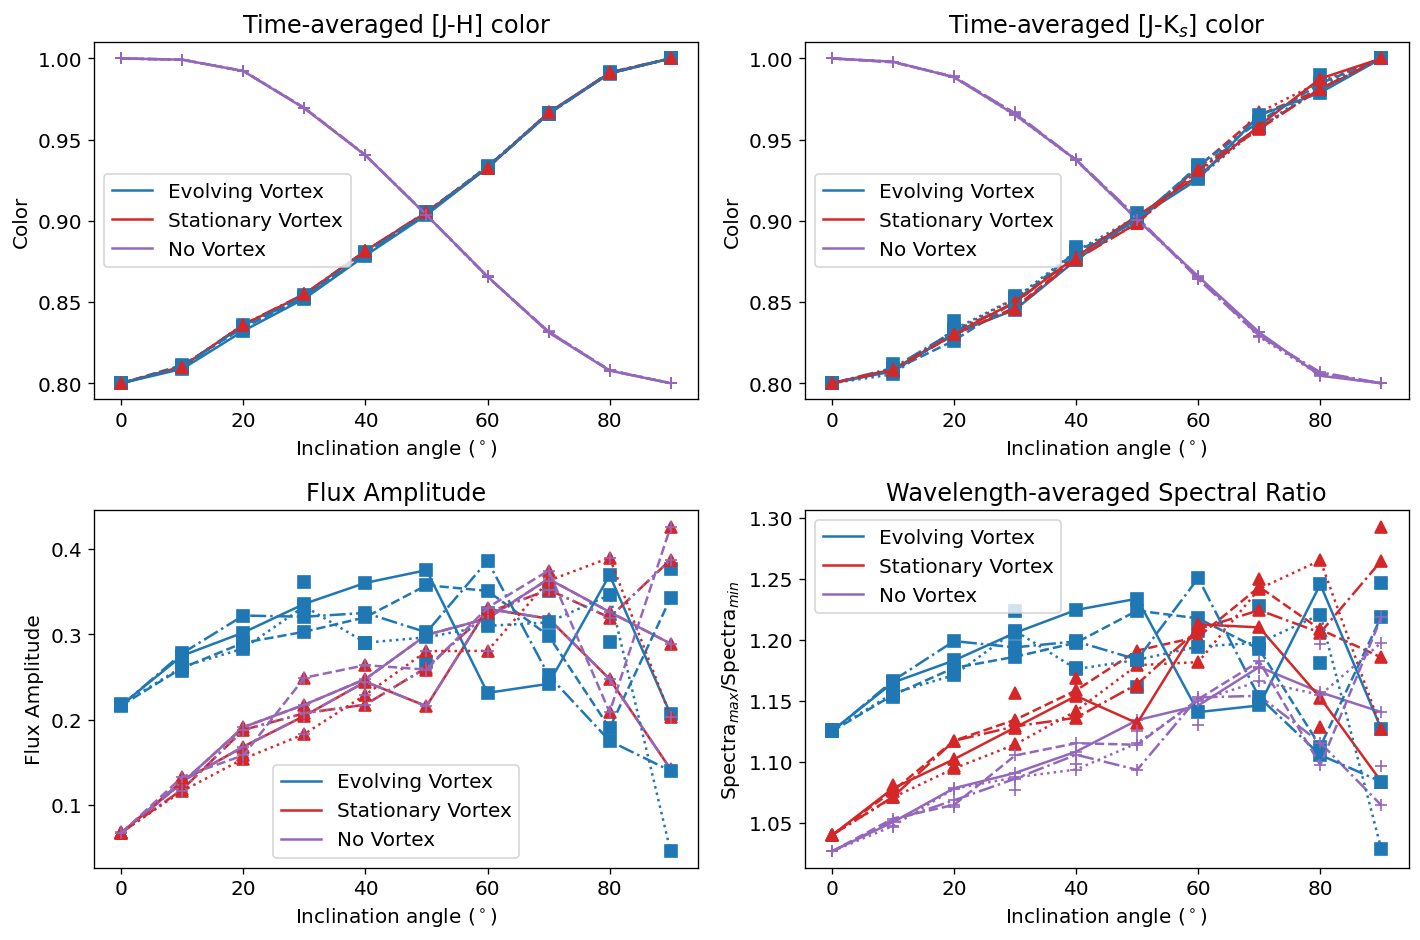

In [124]:
# ==========================================================
## The plot: composite JH-inclination, JK-inclination, 
## variability-inclination, spectra ratio -inclination
# ==========================================================
save = False
# save = True

titles = ['Stationary polar vortex', 'Evolving polar vortex']
fig, axs = plt.subplots(2, 2, figsize=(12, 8), dpi=120)
plt.rcParams.update({'font.size': 12})

colorList = {'polarStatic':'tab:blue', 'polarDynamic':'k', 'noPolar':'tab:red', 'nothing':'tab:purple'}
colorAlias = {'JH_color':'Time-averaged [J-H] color', 'JK_color':r'Time-averaged [J-K$_s$] color', 'silicateIndex':'Si-index'}
markers = ['s', '^', '+']
lsizes = [1.5, 1.25, 1]

# for counter in range(len(production_keys)):
for counter in range(len(production_keys)):
    for n, typename in enumerate(['JH_color', 'JK_color']):
        for i, model in enumerate(['polarStatic', 'noPolar', 'nothing']):
            line, mark = next(linestyleRandomList), markers[i]
            
            x = amplitudes[model][counter][typename][:,0]
            y = amplitudes[model][counter][typename][:,1]

            # rescaling
            scale, offset = np.linalg.solve(b=(0.8, 1.0), a=((np.min(y), 1), (np.max(y), 1)))

            axs[0,n].plot(x+90, y*scale + offset, ls=line, marker=mark, 
                          c=colorList[model], ms=7)

            if n==0:
                y2 = amplitudes[model][counter]['flux'][:,1]
                y3 = amplitudes[model][counter]['specRatio'][:,1]
                axs[1,0].plot(x+90, y2, ls=line, marker=mark, c=colorList[model], ms=7)
                axs[1,1].plot(x+90, y3, ls=line, marker=mark, c=colorList[model], ms=7)
                
                if counter == 0:
                    axs[1,0].plot([], [], ls='-', c=colorList[model], label=aliasList[model])
                    axs[1,1].plot([], [], ls='-', c=colorList[model], label=aliasList[model])
                    axs[0,0].plot([], [], ls='-', c=colorList[model], label=aliasList[model])
                    axs[0,1].plot([], [], ls='-', c=colorList[model], label=aliasList[model])
                
        axs[1,0].legend(), axs[1,1].legend()
        axs[0,n].legend()
        axs[1,n].set_xlabel(r'Inclination angle ($^\circ$)')
        axs[0,n].set_xlabel(r'Inclination angle ($^\circ$)')
        axs[0,n].set_title(colorAlias[typename])

axs[0,0].set_ylabel('Color')
axs[0,1].set_ylabel('Color')
axs[1,0].set_ylabel('Flux Amplitude')
axs[1,1].set_ylabel(r'Spectra$_{max}$/Spectra$_{min}$')
axs[1,0].set_title('Flux Amplitude')
axs[1,1].set_title('Wavelength-averaged Spectral Ratio')

plt.tight_layout()

if save:
    plotOut = plotPath + '/2x2_JH_JK_inclinationTrend'
    plt.savefig(plotOut+'.pdf', dpi=300, format='pdf', bbox_inches = 'tight')
    plt.savefig(plotOut+'.png', dpi=300, format='png', bbox_inches = 'tight')

In [137]:
amplitudes['nothing'][0]['flux']

array([[-9.00000000e+01,  6.74289714e-02],
       [-8.00000000e+01,  1.26241732e-01],
       [-7.00000000e+01,  1.91265039e-01],
       [-6.00000000e+01,  2.17502734e-01],
       [-5.00000000e+01,  2.47597786e-01],
       [-4.00000000e+01,  2.99326432e-01],
       [-3.00000000e+01,  3.18696940e-01],
       [-2.00000000e+01,  3.65004883e-01],
       [-1.00000000e+01,  3.26278906e-01],
       [ 0.00000000e+00,  2.89088216e-01]])

In [140]:
yavg

[[-90.0, 1.0267749220553912],
 [-80.0, 1.038478103181043],
 [-70.0, 1.0492197718741294],
 [-60.0, 1.0592735379225728],
 [-50.0, 1.0682936385188266],
 [-40.0, 1.076358712543605],
 [-30.0, 1.0863590222861141],
 [-20.0, 1.0970110385449419],
 [-10.0, 1.1022807905622083],
 [0.0, 1.1064315779857674]]

#### 2G) Plot inclination trends as averages trendlines of phase Randomizations

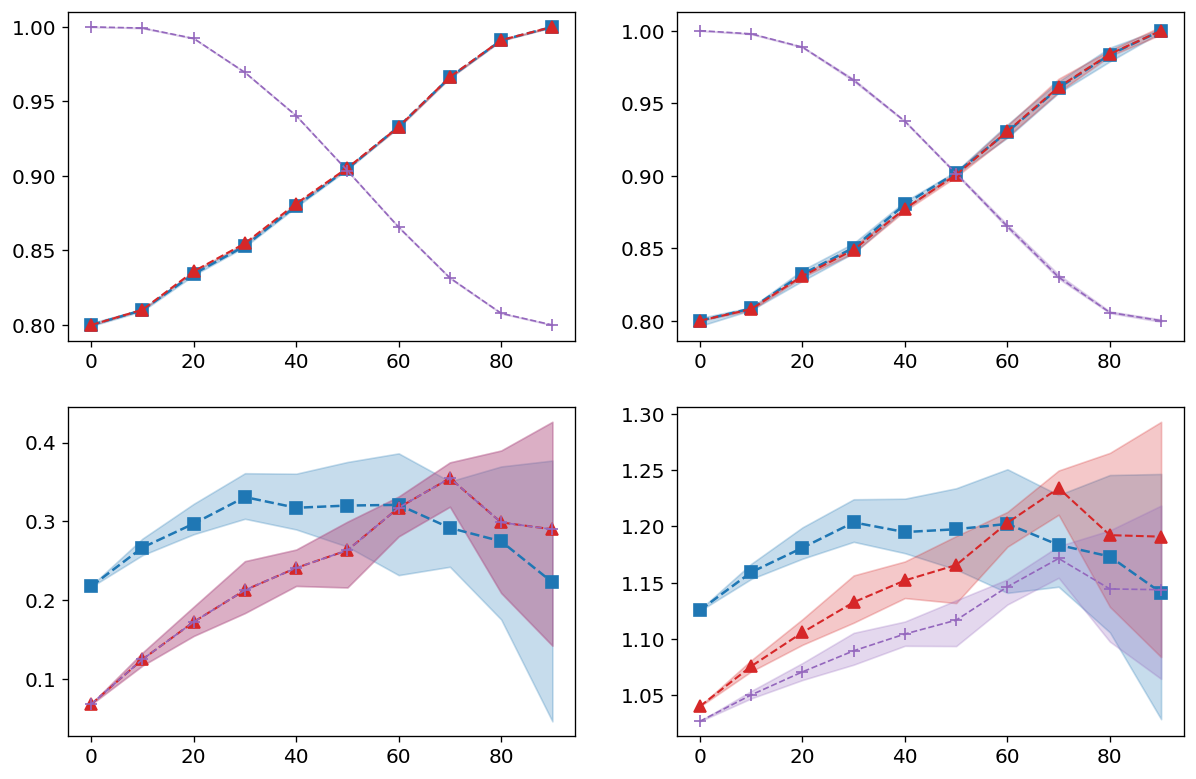

In [145]:
# ==========================================================
## Averaging over all the randPhase config and return mean trendline
# ==========================================================
x_inclination = amplitudes['noPolar'][0]['flux'][:,0]
amplitudes_avg = nested_dict()

colorAlias = {'JH_color':'Time-averaged [J-H] color', 'JK_color':r'Time-averaged [J-K$_s$] color', 'silicateIndex':'Si-index'}

for model in ['polarStatic', 'noPolar', 'nothing']:
    for typename in ['JH_color', 'JK_color', 'flux', 'specRatio']:
        yavg, ymin, ymax = [], [], []
        for i, x in enumerate(x_inclination):
            yrange = []
            for counter in range(len(production_keys)):
                value = amplitudes[model][counter][typename][i,1]
                yrange.append(value)
            yavg.append([x, np.mean(yrange)])
            ymax.append([x, np.max(yrange)])
            ymin.append([x, np.min(yrange)])
        amplitudes_avg[model][typename]['avg'] = np.array(yavg)
        amplitudes_avg[model][typename]['max'] = np.array(ymax)
        amplitudes_avg[model][typename]['min'] = np.array(ymin)
        
#### Plot 2x2 observables with inclinations
fig, axs = plt.subplots(2, 2, figsize=(12, 8), dpi=120)
plt.rcParams.update({'font.size': 12})
markers = ['s', '^', '+']
lsizes = [1.5, 1.25, 1]
offset_list = [0, 0, 0.]
line = '--'
for i, model in enumerate(['polarStatic', 'noPolar', 'nothing']):
    
    JHcolor_avg = amplitudes_avg[model]['JH_color']['avg'][:,1]
    JHcolor_min = amplitudes_avg[model]['JH_color']['min'][:,1]
    JHcolor_max = amplitudes_avg[model]['JH_color']['max'][:,1]
    
    JKcolor_avg = amplitudes_avg[model]['JK_color']['avg'][:,1]
    JKcolor_min = amplitudes_avg[model]['JK_color']['min'][:,1]
    JKcolor_max = amplitudes_avg[model]['JK_color']['max'][:,1]
    
    flux_avg = amplitudes_avg[model]['flux']['avg'][:,1]
    flux_min = amplitudes_avg[model]['flux']['min'][:,1]
    flux_max = amplitudes_avg[model]['flux']['max'][:,1]
    
    specRatio_avg = amplitudes_avg[model]['specRatio']['avg'][:,1]
    specRatio_min = amplitudes_avg[model]['specRatio']['min'][:,1]
    specRatio_max = amplitudes_avg[model]['specRatio']['max'][:,1]
    
    ### JHcolor + rescaling
    scale, offset = np.linalg.solve(b=(0.8, 1.0), a=((np.min(JHcolor_avg), 1), (np.max(JHcolor_avg), 1)))
    axs[0,0].plot(x_inclination+90, JHcolor_avg*scale + offset, ls=line, 
                  lw=lsizes[i], marker=markers[i], c=colorList[model], ms=7, label=aliasList[model])
    
    axs[0,0].fill_between(x_inclination+90, JHcolor_max*scale + offset, JHcolor_min*scale + offset,
                          color=colorList[model], alpha = 0.25)
    
    ### JKcolor + rescaling
    scale, offset = np.linalg.solve(b=(0.8, 1.0), a=((np.min(JKcolor_avg), 1), (np.max(JKcolor_avg), 1)))
    axs[0,1].plot(x_inclination + 90, JKcolor_avg*scale + offset, ls=line, 
                  lw=lsizes[i], marker=markers[i], c=colorList[model], ms=7, label=aliasList[model])
    
    axs[0,1].fill_between(x_inclination+90, JKcolor_max*scale + offset, JKcolor_min*scale + offset,
                          color=colorList[model], alpha = 0.25)
    
    ### flux
    axs[1,0].plot(x_inclination+90, flux_avg-offset_list[i], ls=line, lw=lsizes[i], 
                  marker=markers[i], c=colorList[model], ms=7, label=aliasList[model])
                          
    axs[1,0].fill_between(x_inclination+90, flux_max, flux_min, color=colorList[model], alpha = 0.25)

    ### spectral ratio
    axs[1,1].plot(x_inclination+90, specRatio_avg, ls=line, lw=lsizes[i], 
                  marker=markers[i], c=colorList[model], ms=7, label=aliasList[model])
                          
    axs[1,1].fill_between(x_inclination+90, specRatio_max, specRatio_min, color=colorList[model], alpha = 0.25)
    
#### formatting
for n, typename in ['JH_color', 'JK_color']:
    
axs[1,0].legend()
axs[1,n].set_xlabel(r'Inclination angle ($^\circ$)')
axs[0,n].set_xlabel(r'Inclination angle ($^\circ$)')
axs[0,n].set_title(colorAlias[typename])
    
axs[0,0].set_ylabel('Color')
axs[0,1].set_ylabel('Color')
axs[1,0].set_ylabel('Flux Amplitude')
axs[1,1].set_ylabel(r'Spectra$_{max}$/Spectra$_{min}$')
axs[1,0].set_title('Flux Amplitude')
axs[1,1].set_title('Wavelength-averaged Spectral Ratio')

In [106]:
amplitudes_avg[model]['JH_color'][:][1]

[-80.0, 184.4614713235992]

## Step 3: Reproduce color-inclination trends in literature

#### 3A) [read, create] Read external datas and plots
- Vos 2017:
    + **Color anomaly**: Median 2MASS J−Ks color subtracted from the J−Ks color of the objects. Median colors for L0–T6 objects were taken from Schmidt et al. (2010). T7 J−Ks color to be −0.04±0.43
- Suarez 2023:
    + Table 1: Silicate index
    + Table 2: Colors

In [30]:
# =========== Vos 2017 Data ===============
# vos17dataPath = "/Users/nguyendat/Documents/GitHub/polar_vortice/PolarVortice/spitzerData/processed/vos_2017_table.csv"
# nameList = ['Spt','3.6Amp','3.6AmpErr','JAmp','JAmpErr','KepAmp',
#             'Period','PeriodErr','vsini','vsiniErr','JKscolor',
#             'Inclination','inclinationErr','JKanomaly','JKanomalyErr']
# vos17 = pd.read_csv(vos17dataPath, names=nameList, delimiter=';', skiprows=1)

vos17dataPath = '/Users/nguyendat/Documents/GitHub/polar_vortice/PolarVortice/spitzerData/processed/vos_JK_color_anomaly_handInput.csv'
nameList = ['No', 'Inclination', 'JKanomaly', 'inclinationErr1', 'inclinationErr2',
            'JKanomalyErr1', 'JKanomalyErr2']
vos17 = pd.read_csv(vos17dataPath, names=nameList, delimiter=';', skiprows=1)
vos17['inclinationErr1'] = vos17['Inclination'] - vos17['inclinationErr1']
vos17['inclinationErr2'] = vos17['inclinationErr2'] - vos17['Inclination']
vos17['JKanomalyErr1'] = vos17['JKanomaly'] - vos17['JKanomalyErr1']
vos17['JKanomalyErr2'] = vos17['JKanomalyErr2'] - vos17['JKanomaly']

# =========== Suarez 2023 Data ===============
suarez23table1Path = "/Users/nguyendat/Documents/GitHub/polar_vortice/PolarVortice/spitzerData/processed/suarez_2023_table1.csv"
suarez23table1Name = ["2MASSName","ShortName"," SpT(opt)",
                      "Reference1","SpT(IR)","Reference2","SilicateIndex",
                      "Si_err","Inc","IncErr","Reference"]
suarez23table1 = pd.read_csv(suarez23table1Path, delimiter=',', names=suarez23table1Name, skiprows=1)
### 
suarez23table2Path = "/Users/nguyendat/Documents/GitHub/polar_vortice/PolarVortice/spitzerData/processed/suarez_2023_table2.csv"
suarez23table2Name = ["ShortName","J","Jerr","H","Herr",
                      "Ks","Kserr","W1","W1err",
                      "W2","W2err","J-Ks","W1-W2"]
suarez23table2 = pd.read_csv(suarez23table2Path, names=suarez23table2Name, delimiter=',', skiprows=1)
###
suarez23 = suarez23table2.merge(suarez23table1, on='ShortName', how='right')
suarez23['J-H'] = suarez23.J - suarez23.H
suarez23.columns

Index(['ShortName', 'J', 'Jerr', 'H', 'Herr', 'Ks', 'Kserr', 'W1', 'W1err',
       'W2', 'W2err', 'J-Ks', 'W1-W2', '2MASSName', ' SpT(opt)', 'Reference1',
       'SpT(IR)', 'Reference2', 'SilicateIndex', 'Si_err', 'Inc', 'IncErr',
       'Reference', 'J-H'],
      dtype='object')

#### 3B) [plot] Plot Suarez23 color-inclination and silicateIndex-inclination from data

Text(0.5, 1.0, 'Silicate Index vs inclination')

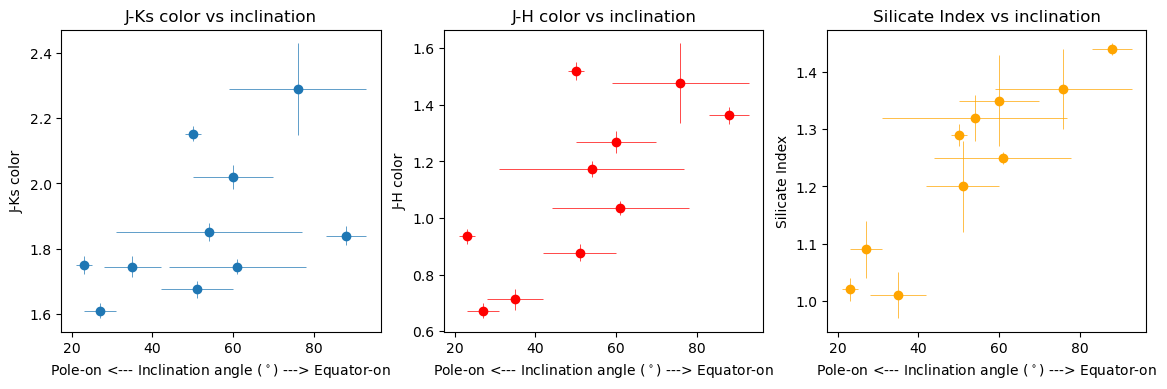

In [33]:
# # =========== plot a J-K color - inclination diagram ===========
# plt.close()
# fig, (ax1, ax2, ax3) = plt.subplots(1,3, dpi=100, figsize=(14,4))

# inclination = suarez23['Inc']
# incErr = suarez23['IncErr']
# J, Ks = suarez23['J'], suarez23['Ks']
# Jerr, Kserr = suarez23['Jerr'], suarez23['Kserr']
# largerErr = []
# for i in range(len(Jerr)):
#     if Jerr[i] > Kserr[i]:
#         largerErr.append(Jerr[i])
#     else:
#         largerErr.append(Kserr[i])
# JKscolor = suarez23['J-Ks']

# ax1.errorbar(x=inclination, y=JKscolor, xerr=incErr, yerr=largerErr, ls='', marker='o', lw=0.5)
# ax1.set_xlabel(r'Pole-on <--- Inclination angle ($^\circ$) ---> Equator-on')
# ax1.set_ylabel('J-Ks color')
# ax1.set_title('J-Ks color vs inclination')

# # =========== plot a J-H color - inclination diagram ===========

# J, H = suarez23['J'], suarez23['H']
# Jerr, Herr = suarez23['Jerr'], suarez23['Herr']
# largerErr = []
# for i in range(len(Jerr)):
#     if Jerr[i] > Herr[i]:
#         largerErr.append(Jerr[i])
#     else:
#         largerErr.append(Herr[i])
# JHcolor = suarez23['J-H']

# ax2.errorbar(x=inclination, y=JHcolor, xerr=incErr, yerr=largerErr, c='r', ls='', marker='o', lw=0.5)
# ax2.set_xlabel(r'Pole-on <--- Inclination angle ($^\circ$) ---> Equator-on')
# ax2.set_ylabel('J-H color')
# ax2.set_title('J-H color vs inclination')

# # =========== plot a silicate index - inclination diagram ===========
# siIndex = suarez23.SilicateIndex
# siErr = suarez23.Si_err
# ax3.errorbar(x=inclination, y=siIndex, xerr=incErr, yerr=siErr, c='orange', ls='', marker='o', lw=0.5)
# ax3.set_xlabel(r'Pole-on <--- Inclination angle ($^\circ$) ---> Equator-on')
# ax3.set_ylabel('Silicate Index')
# ax3.set_title('Silicate Index vs inclination')

#### 3C) [plot] Plot Vos17 J-K color anomaly

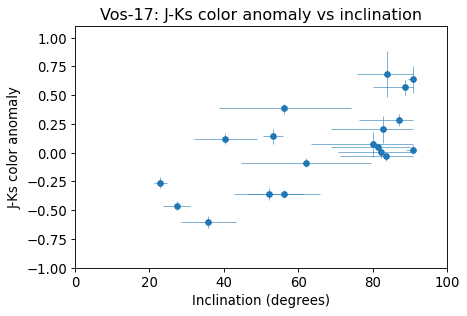

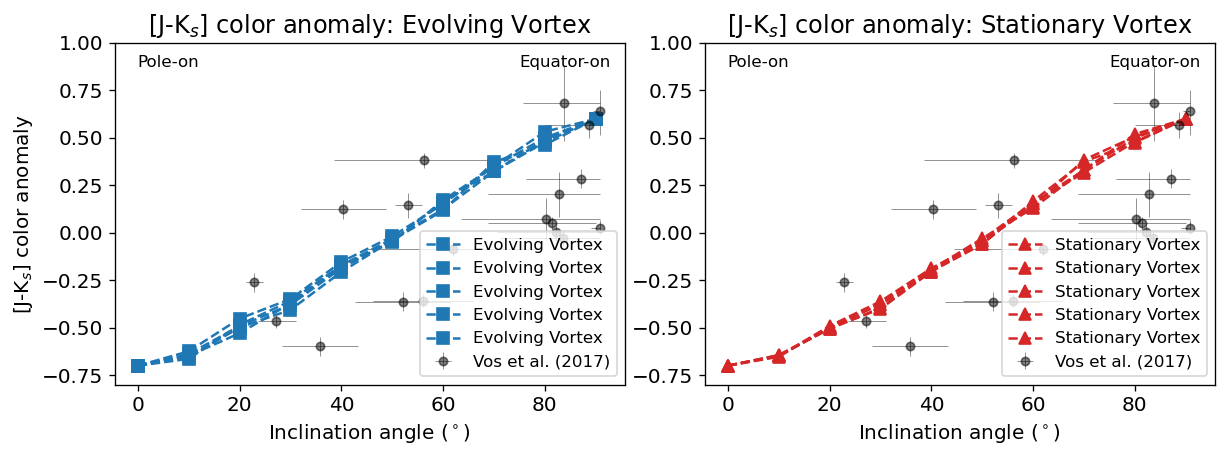

In [33]:
# =========== plot a J-K color anomaly - inclination diagram ===========
plt.close()
plt.rcParams.update({'font.size': 12})
fig, ax1 = plt.subplots(dpi=80, figsize=(6,4))

inclination = vos17['Inclination']
incErr1 = vos17['inclinationErr1'].values
incErr2 = vos17['inclinationErr2'].values
xerrs = np.array([incErr1, incErr2])

JKscolorAnomaly = vos17['JKanomaly']
JKanomalyErr1 = vos17['JKanomalyErr1'].values
JKanomalyErr2 = vos17['JKanomalyErr2'].values
yerrs = np.array([JKanomalyErr1, JKanomalyErr2])

ax1.errorbar(x=inclination, y=JKscolorAnomaly, xerr=xerrs, 
             yerr=yerrs, ls='', marker='o', lw=0.5, ms=5)
ax1.set_xlabel('Inclination (degrees)')
ax1.set_ylabel('J-Ks color anomaly')
ax1.set_title('Vos-17: J-Ks color anomaly vs inclination')
ax1.set_xlim(0, 100)
ax1.set_ylim(-1,1.1)

# ==========================================================
## The plot: J-Ks color
# ==========================================================
titles = ['No polar variation', 'With polar variation']
# for typename in ['JH_color', 'continuumRatio']:

# save = True
save = False

# fsed=1
fig, axs = plt.subplots(1,2, figsize=(10,3.5), dpi=120)#, gridspec_kw={'width_ratios':[3, 1.5, 3, 1.5]})

markers = ['s', '^']

for typename in ['JK_color']:

    plt.tight_layout(w_pad=1, pad=1)
    # fig.suptitle('%s with inclination i'%typename)
    for i, model in enumerate(['polarStatic', 'noPolar']):
        for counter in range(len(production_keys)):
            
            x = amplitudes[model][counter][typename][:,0]
            y = amplitudes[model][counter][typename][:,1]

            # rescaling
            scale, offset = np.linalg.solve(b=(-0.7, 0.6), a=((np.min(y), 1), (np.max(y), 1)))

            axs[i].plot(x+90, scale*y + offset, ls='--', marker=markers[i], c=colorList[model], ms=7, label=aliasList[model])

        ### plot the null case: 'nothing'
        # ynull = amplitudes['nothing'][typename][:,1]
        # axs[i].plot(x+90, scaling2*ynull +offset2, ls='--', marker=markers[i], c=colorList[model], ms=7, label=aliasList[model])

        axs[i].set_xlabel(r'Inclination angle ($^\circ$)')
        axs[i].set_title(r'[J-K$_s$] color anomaly: '+aliasList[model])
        ### Plot Vos2017 color anomaly trend
        axs[i].errorbar(x=inclination, y=JKscolorAnomaly, xerr=xerrs, 
             yerr=yerrs, ls='', marker='o', lw=0.5, ms=5, c='k', alpha=0.5, label = 'Vos et al. (2017)')
        axs[i].legend(loc='lower right', fontsize=10)
        axs[i].set_ylim(-0.8,1.0)

    axs[0].text(0, 0.875, 'Pole-on', fontsize=10), axs[0].text(75, 0.875, 'Equator-on', fontsize=10)
    axs[1].text(0, 0.875, 'Pole-on', fontsize=10), axs[1].text(75, 0.875, 'Equator-on', fontsize=10)

    axs[0].set_ylabel('[J-K$_s$] color anomaly')

if save:
    plotOut = plotPath + '/1x2_JKColorAnomaly_vsInclination_trend'
    plt.savefig(plotOut+'.pdf', dpi=300, format='pdf', bbox_inches = 'tight')
    plt.savefig(plotOut+'.png', dpi=300, format='png', bbox_inches = 'tight')

#### 3C1.5)  [plot] subroutine for third modelclass: 'nothing' - JK color/inclination

(-0.8, 1.0)

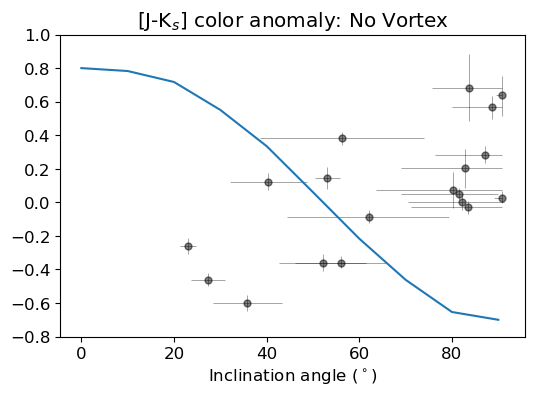

In [35]:
plt.close()
fig, ax = plt.subplots(figsize=(6,4), dpi=100)
xnull = amplitudes['nothing']['JK_color'][:,0]
ynull = amplitudes['nothing']['JK_color'][:,1]

# rescaling
scale2, offset2 = np.linalg.solve(b=(-0.7, 0.8), a=((np.min(ynull), 1), (np.max(ynull), 1)))

ax.plot(xnull+90, scale2*ynull + offset2)
ax.set_xlabel(r'Inclination angle ($^\circ$)')
ax.set_title(r'[J-K$_s$] color anomaly: '+aliasList['nothing'])

ax.errorbar(x=inclination, y=JKscolorAnomaly, xerr=xerrs,  yerr=yerrs, ls='', marker='o', lw=0.5, ms=5, c='k', alpha=0.5, label = 'Vos et al. (2017)')
ax.set_ylim(-0.8,1.0)

#### 3D) [plot] Model J-K color anomaly trend plus third scenario

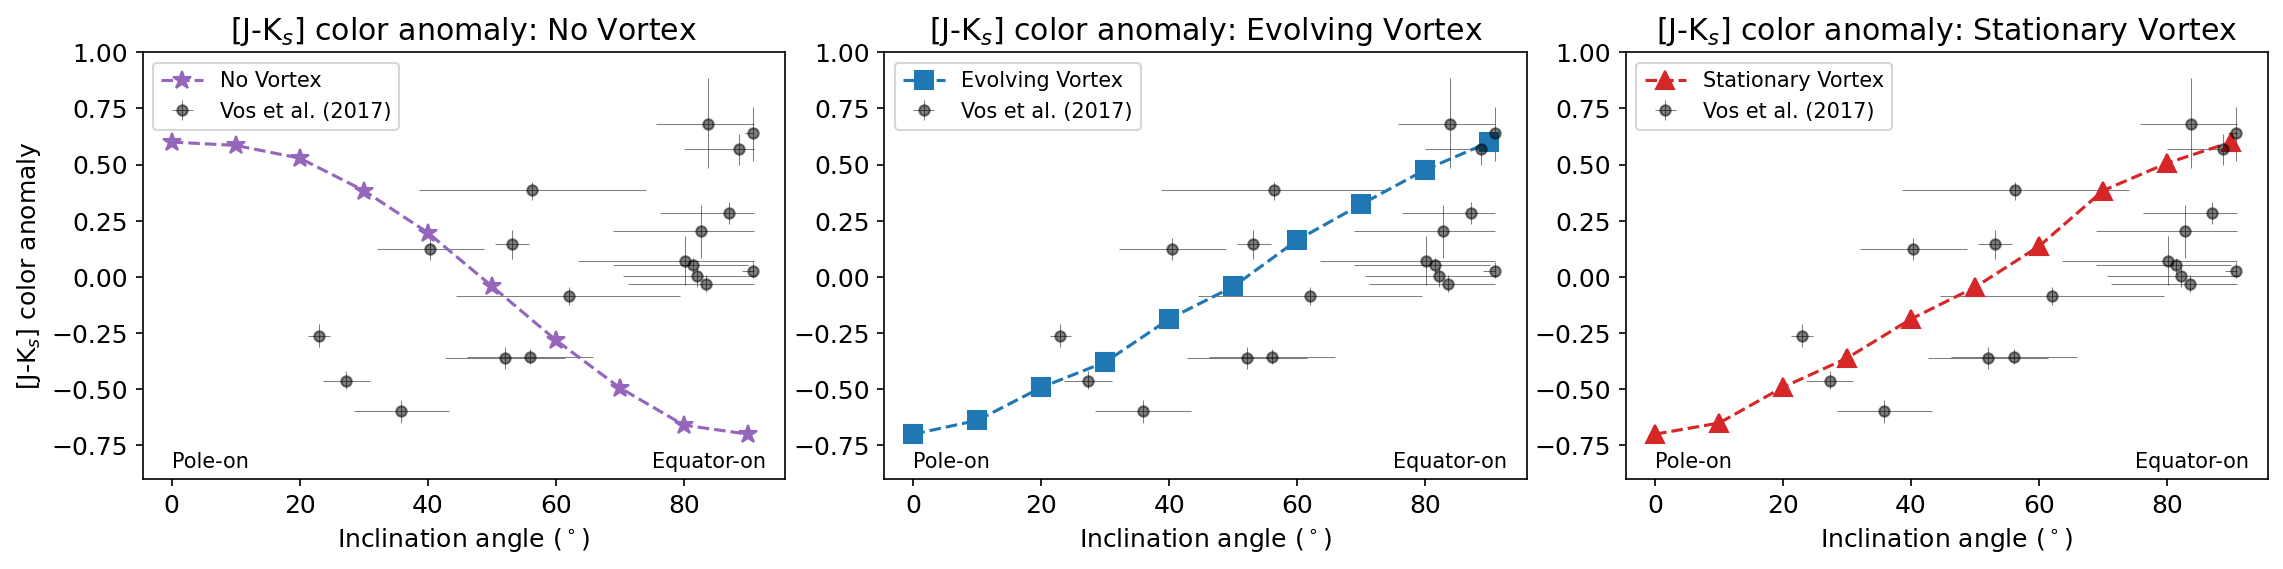

In [36]:
# =========== plot a J-K color anomaly - inclination diagram ===========
plt.close()
plt.rcParams.update({'font.size': 12})

# ==========================================================
## The plot: J-Ks color
# ==========================================================
# titles = ['No polar variation', 'With polar variation', 'Nothing']
# for typename in ['JH_color', 'continuumRatio']:

colorList = {'polarStatic':'tab:blue', 'polarDynamic':'k', 'noPolar':'tab:red', 'nothing':'tab:purple'}

# save = True
save = False

# fsed=1
markers = ['*', 's', '^']
for typename in ['JK_color']:
    fig, axs = plt.subplots(1,3, figsize=(15,3.5), dpi=150)#, gridspec_kw={'width_ratios':[3, 1.5, 3, 1.5]})
    plt.tight_layout(w_pad=1, pad=1)
    # fig.suptitle('%s with inclination i'%typename)
    for i, model in enumerate(['nothing', 'polarStatic', 'noPolar']):
        x = amplitudes[model][typename][:,0]
        y = amplitudes[model][typename][:,1]
        
        # rescaling
        scale, offset = np.linalg.solve(b=(-0.7, 0.6), a=((np.min(y), 1), (np.max(y), 1)))
        
        axs[i].plot(x+90, scale*y + offset, ls='--', marker=markers[i], c=colorList[model], ms=9, label=aliasList[model])
        
        ### plot the null case: 'nothing'
        # ynull = amplitudes['nothing'][typename][:,1]
        # axs[i].plot(x+90, scaling2*ynull +offset2, ls='--', marker=markers[i], c=colorList[model], ms=7, label=aliasList[model])
        
        axs[i].set_xlabel(r'Inclination angle ($^\circ$)')
        axs[i].set_title(r'[J-K$_s$] color anomaly: '+aliasList[model])
        ### Plot Vos2017 color anomaly trend
        axs[i].errorbar(x=inclination, y=JKscolorAnomaly, xerr=xerrs, 
             yerr=yerrs, ls='', marker='o', lw=0.5, ms=5, c='k', alpha=0.5, label = 'Vos et al. (2017)')
        axs[i].legend(fontsize=10)
        axs[i].set_ylim(-0.9,1.0)
    
        axs[i].text(0, -0.85, 'Pole-on', fontsize=10), axs[i].text(75, -0.85, 'Equator-on', fontsize=10)
    
    axs[0].set_ylabel('[J-K$_s$] color anomaly')

if save:
    plotOut = plotPath + '/1x3_JKColorAnomaly_vsInclination_trend'
    plt.savefig(plotOut+'.pdf', dpi=300, format='pdf', bbox_inches = 'tight')
    plt.savefig(plotOut+'.png', dpi=300, format='png', bbox_inches = 'tight')

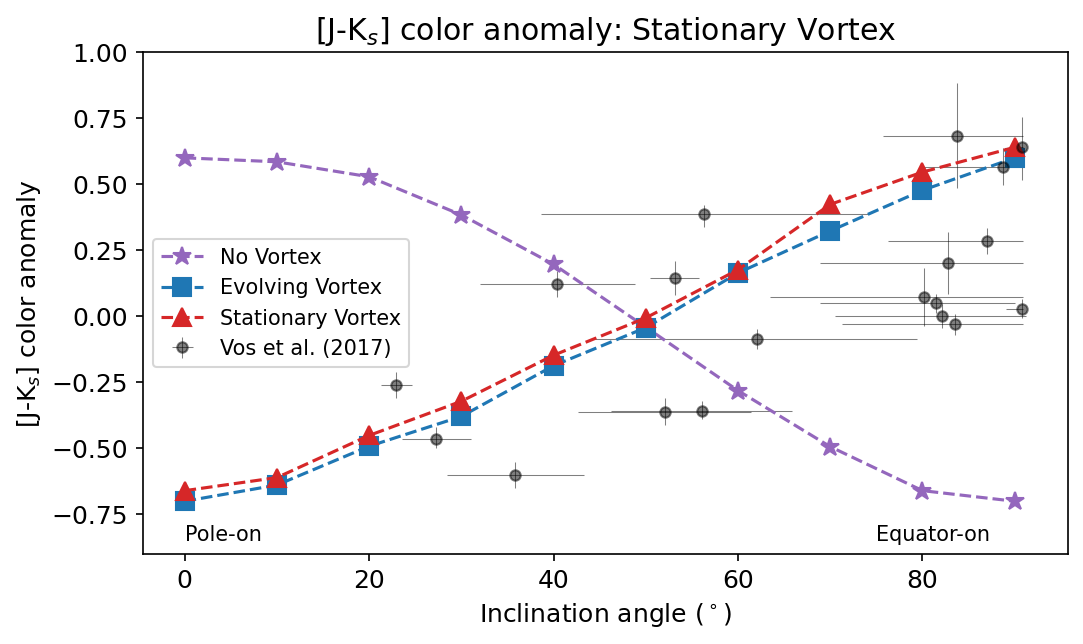

In [37]:
# =========== plot a J-K color anomaly - inclination diagram ===========
plt.close()
plt.rcParams.update({'font.size': 12})

# ==========================================================
## The plot: J-Ks color
# ==========================================================
# titles = ['No polar variation', 'With polar variation', 'Nothing']
# for typename in ['JH_color', 'continuumRatio']:

colorList = {'polarStatic':'tab:blue', 'polarDynamic':'k', 'noPolar':'tab:red', 'nothing':'tab:purple'}

# save = True
save = False

# fsed=1
markers = ['*', 's', '^']
for typename in ['JK_color']:
    fig, axs = plt.subplots(figsize=(7, 4), dpi=150)#, gridspec_kw={'width_ratios':[3, 1.5, 3, 1.5]})
    plt.tight_layout(w_pad=1, pad=1)
    
    for i, model in enumerate(['nothing', 'polarStatic', 'noPolar']):
        x = amplitudes[model][typename][:,0]
        y = amplitudes[model][typename][:,1]
        
        # rescaling
        scale, offset = np.linalg.solve(b=(-0.7, 0.6), a=((np.min(y), 1), (np.max(y), 1)))
        if model == 'noPolar': offset+=0.04
        axs.plot(x+90, scale*y + offset, ls='--', marker=markers[i], c=colorList[model], ms=9, label=aliasList[model])
             
    axs.set_xlabel(r'Inclination angle ($^\circ$)')
    axs.set_title(r'[J-K$_s$] color anomaly: '+aliasList[model])
    ### Plot Vos2017 color anomaly trend
    axs.errorbar(x=inclination, y=JKscolorAnomaly, xerr=xerrs, 
         yerr=yerrs, ls='', marker='o', lw=0.5, ms=5, c='k', alpha=0.5, label = 'Vos et al. (2017)')
    axs.legend(fontsize=10)
    axs.set_ylim(-0.9,1.0)

    axs.text(0, -0.85, 'Pole-on', fontsize=10)
    axs.text(75, -0.85, 'Equator-on', fontsize=10)
    
    axs.set_ylabel('[J-K$_s$] color anomaly')

if save:
    plotOut = plotPath + '/1x1_JKColorAnomaly_vsInclination_trend_OnePlot'
    plt.savefig(plotOut+'.pdf', dpi=300, format='pdf', bbox_inches = 'tight')
    plt.savefig(plotOut+'.png', dpi=300, format='png', bbox_inches = 'tight')

#### 3E) [plot, create] Plot three scenarios (+'nothing') of images of atmosphere.

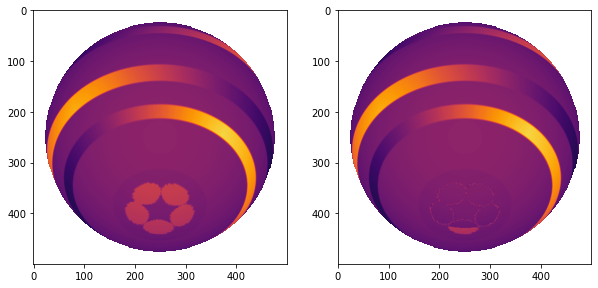

In [38]:
%matplotlib inline
plt.close()
iang='-50'
t = 50
totalImageTarget = images['polarStatic'][iang][t][0]
totalImageNew = totalImageTarget.copy()
polImageTarget = images['polarStatic'][iang][t][3]

meta_iang = metadatas[productionKey]['polarStatic'][iang][photo_config0]
specmap = meta_iang['specmap']
is_pol = ((specmap >= con_pol[0]) & (specmap < con_pol[1])).astype(int)

# ========================================================================
#### Create sample image for third scenario by removing vortices.
totalImageNew = totalImageTarget.copy()
for xx in range(specmap.shape[0]):
    for yy in range(specmap.shape[1]):
        if is_pol[xx,yy]:
            if totalImageNew[xx,yy] > 0.38:
                totalImageNew[xx,yy] = totalImageTarget[xx,yy]-0.168
for xx in range(specmap.shape[0]):
    for yy in range(specmap.shape[1]):
        if is_pol[xx,yy]:
            if 0.23 < totalImageNew[xx,yy] < 0.27:
                totalImageNew[xx,yy] = totalImageTarget[xx,yy]+0.001
            if 0.272 < totalImageNew[xx,yy] < 0.3:
                totalImageNew[xx,yy] = totalImageTarget[xx,yy]+0.001

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
# ========================================================================

ax1.imshow(totalImageTarget, vmin=0, vmax=1, cmap='inferno')
ax2.imshow(totalImageNew, vmin=0, vmax=1, cmap='inferno')

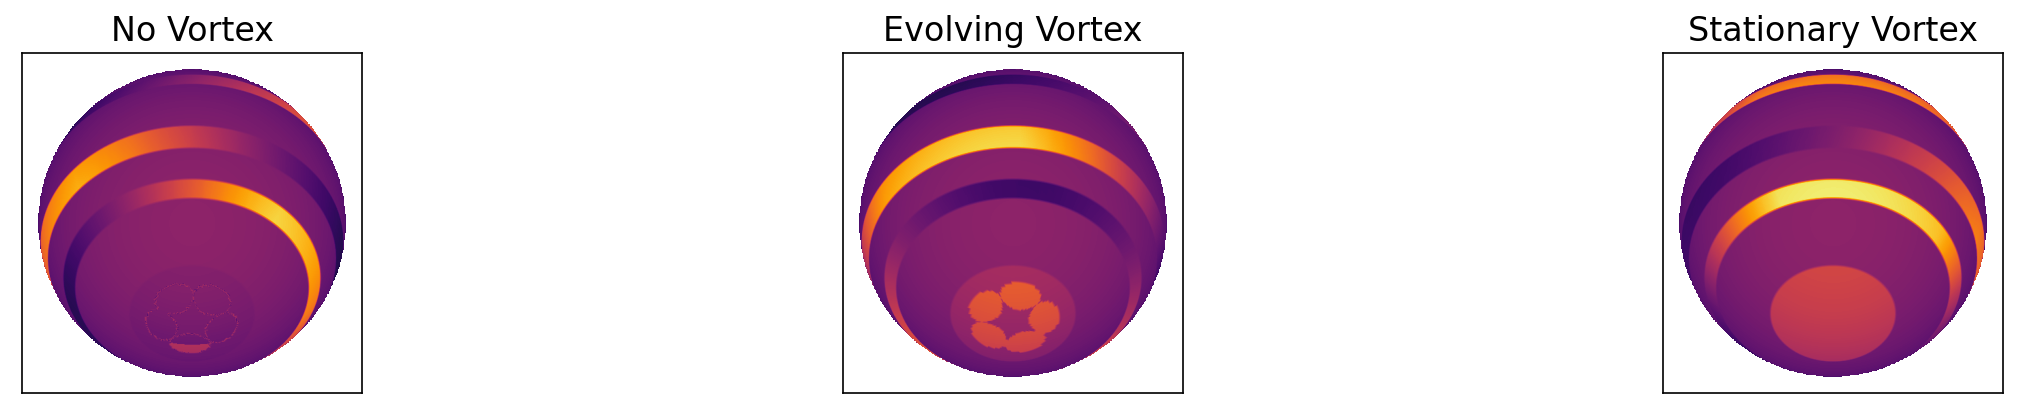

In [39]:
plt.close()
fig, axs = plt.subplots(1,3, figsize=(20,3), dpi=150)#, gridspec_kw={'width_ratios':[3, 1.5, 3, 1.5]})

# save = True
save = False
iang='-50'

im1 = images['polarStatic'][iang][5][0]
im2 = images['noPolar'][iang][5][0]
im3 = totalImageNew
im = [im3, im1, im2]

aliasList[model]

for i, model in enumerate(['nothing', 'polarStatic', 'noPolar']):
    axs[i].imshow(im[i], vmin=0, vmax=1, cmap='inferno')
    axs[i].set_xticks([]), axs[i].set_yticks([])
    axs[i].set_title(aliasList[model], fontsize=16)

if save:
    plotOut = plotPath + '/1x3_supplement_plot_threeScenarios'
    plt.savefig(plotOut+'.pdf', dpi=300, format='pdf', bbox_inches = 'tight')
    plt.savefig(plotOut+'.png', dpi=300, format='png', bbox_inches = 'tight')

## Step 4: Replot some of the important plots including third scenario: 'nothing'

#### 4A) [plot]: extra synthetic atmosphere model plot: Panel E for plot in 2A2)

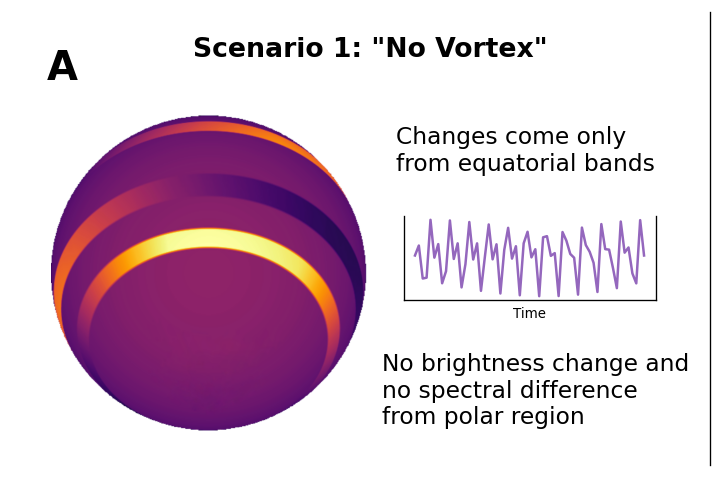

In [40]:
### 2x2 Figure Synthetic Atmosphere Model, Annotated Plots
save = False
# save = True

# Read healed imaged of 'nothing' atmosphere
import matplotlib.image as mpimg
img = mpimg.imread('/Users/nguyendat/Documents/GitHub/polar_vortice/PolarVortice/totalImageNoVortexNothing.png')

plt.close()
fig, axs = plt.subplots(figsize=(7.5, 5), dpi=120)
axs.set_xticks([])
axs.set_yticks([])
plt.subplots_adjust(wspace=0, hspace=0)

# turn off border
axs.spines['top'].set_visible(False)
axs.spines['left'].set_visible(False)
axs.spines['bottom'].set_visible(False)

# ==================== Plot 5: nothing case =========================
left, bottom, width, height = [0.08, 0.18, 0.53, 0.53]
subax = fig.add_axes([left, bottom, width, height])
subax.axis('off')
# subax.imshow(totalImageNew, cmap='inferno')
subax.imshow(img)
subax.set_xticks([])
subax.set_yticks([])

# subax3b: long-period polar flux plot
left, bottom, width, height = [0.56, 0.40, 0.28, 0.14]
subaxb = fig.add_axes([left, bottom, width, height])
subaxb.plot(time_array, fluxes['polarStatic']['-50']['bytype']['band'], marker='', color='tab:purple')
subaxb.spines['top'].set_visible(False), subax3b.spines['right'].set_visible(False)
subaxb.set_xlabel('Time', fontsize=8), subax3b.set_ylabel('Flux', fontsize=8)
subaxb.set_xticks([])
subaxb.set_yticks([])

#### Annotations =================================
# ===== Plot 4 =====
axs.text(0.05, 0.85, 'A', fontsize=24, weight='bold')
axs.text(0.26, 0.90, 'Scenario 1: "No Vortex"', weight='bold', fontsize=16)

axs.text(0.55, 0.65, 'Changes come only\nfrom equatorial bands', fontsize=14)
axs.text(0.53, 0.09, 'No brightness change and\nno spectral difference\nfrom polar region', fontsize=14)

if save:
    plotOut = plotPath + '/[extraThird]_synthetic_atmosphere_model'
    plt.savefig(plotOut+'.pdf', dpi=300, format='pdf', bbox_inches = 'tight')
    plt.savefig(plotOut+'.png', dpi=300, format='png', bbox_inches = 'tight')

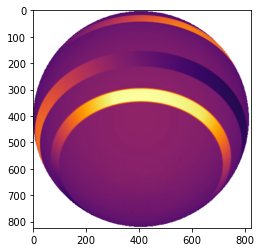

In [41]:
import matplotlib.image as mpimg
img = mpimg.imread('/Users/nguyendat/Documents/GitHub/polar_vortice/PolarVortice/totalImageNoVortexNothing.png')
imgplot = plt.imshow(img)
plt.show()

#### 4B) [plot]: photspec evol. with extra scenario: third row for plot in 2D)

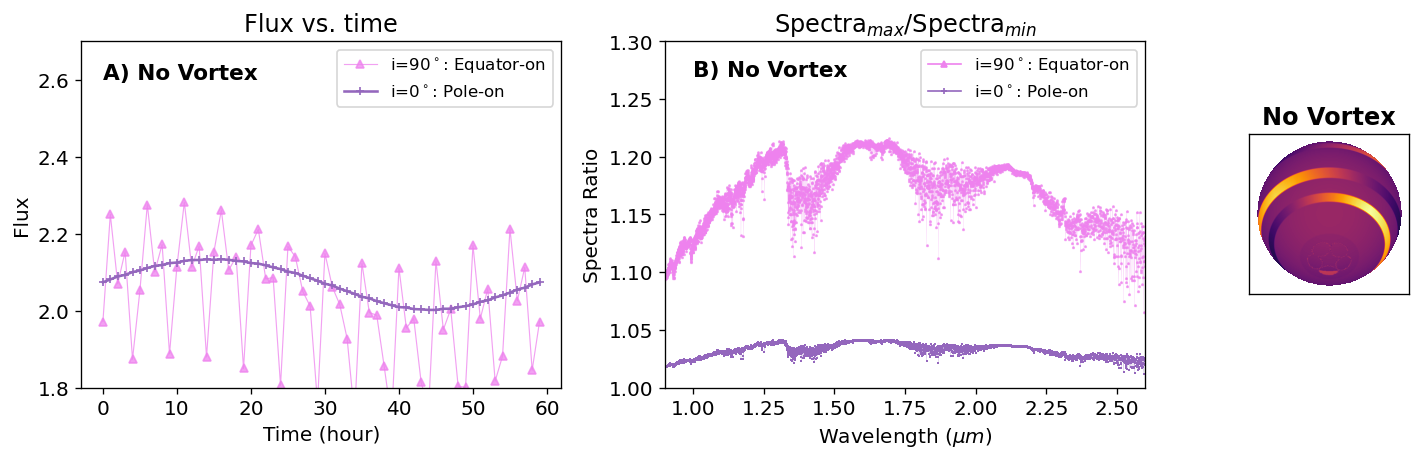

In [42]:
# ================================================================================
# [[Plot]]
# Spectra cube test plots for two inclination, by model class 
# 1) spectras at all timestamps, two model classes: blue and red
# 2) flux evolution by time, two model classes: blue and red
# ================================================================================
# save = True
save = False

plt.close()
plt.rcParams.update({'font.size': 12})

f, axs = plt.subplots(1, 3, figsize=(12,4), dpi=120, gridspec_kw={'width_ratios':[3, 3, 1]})
incliMarketList = ['^', '+', '.']
lwList = [0.7, 1.55, 2.3]
lsList = ['-', '-', '-']
alphaList = [0.75, 1., 1.]
colorsList = ['violet', 'tab:purple', 'purple']
# colorsList = [['teal', 'darkblue'], ['tab:orange', 'darkred'], ]
labelOnList = {0: 'Pole-on', 90: 'Equator-on'}

# for n, iang in enumerate(['0', '-50','-90']):
for n, iang in enumerate(['0', '-90']):
    iNum = int(iang)+90

    ### flux plots
    fluxArray = 0.975*fluxes['noPolar'][iang]['norm']
    axs[0].plot(time_array, fluxArray, c=colorsList[n], 
                  ls=lsList[n], lw=lwList[n], marker=incliMarketList[n], 
                  ms=5, label='i=%i$^\circ$'%iNum+': '+labelOnList[iNum], alpha=alphaList[n])

    ### spectra plots
    t_fluxmin = fluxes['noPolar'][iang]['norm'].argmin()
    t_fluxmax = fluxes['noPolar'][iang]['norm'].argmax()
    spec_fluxmin = spectral_cube['nothing'][iang]['spectra'][t_fluxmin]
    spec_fluxmax = spectral_cube['nothing'][iang]['spectra'][t_fluxmax]
    spec_ratio = spec_fluxmax / spec_fluxmin
    axs[1].plot(lam, spec_ratio, ls='-', lw=0.1, 
                  marker=incliMarketList[n], ms=1, c=colorsList[n], alpha=alphaList[n])
    axs[1].plot([], [], ls='-', marker=incliMarketList[n], c=colorsList[n], ms=4, lw=1
                  ,label='i=%i$^\circ$'%iNum+': '+labelOnList[iNum])

axs[0].legend(fontsize=10)
axs[0].set_ylabel('Flux')
axs[0].set_xlabel('Time (hour)')
axs[0].legend(fontsize=10)
axs[0].set_ylim(1.8, 2.7)

axs[1].legend(fontsize=10)
axs[1].set_xlim(0.90, 2.60)
axs[1].set_ylim(1.0, 1.30)
axs[1].set_ylabel('Spectra Ratio')
axs[1].set_xlabel(r'Wavelength ($\mu m$)')

axs[1].set_title(r'Spectra$_{max}$/Spectra$_{min}$')
axs[0].set_title(r'Flux vs. time')

axs[0].text(0, 2.6, 'A) No Vortex', fontsize=13, weight='bold')
# axs[0].text(0, 2.55, 'Pole-on: higher amplitude', fontsize=10)
# axs[0].text(0, 2.6, 'C) Stationary Vortex', fontsize=13, weight='bold')
# axs[0].text(0, 2.55, 'Pole-on: lower amplitude', fontsize=10)

axs[1].text(1.0, 1.27, 'B) No Vortex', fontsize=13, weight='bold')
# # axs[0,1].text(1.0, 1.2, 'Pole-on: higher ', fontsize=10)
# axs[1,1].text(0.97, 1.27, 'D) Stationary Vortex', fontsize=13, weight='bold')
# axs[1,1].text(25, 1.85, 'Pole-on: lower amplitude', fontsize=12)

### imshow
# axs[0,2].axis('off')
axs[2].imshow(totalImageNew, cmap='inferno')
axs[2].set_title('No Vortex', weight='bold')
axs[2].set_xticks([])
axs[2].set_yticks([])

plt.tight_layout() 

if save:
    plotOut = plotPath + '/[extraThird]_photSpecEvolution'
    plt.savefig(plotOut+'.pdf', dpi=300, format='pdf', bbox_inches = 'tight')
    plt.savefig(plotOut+'.png', dpi=300, format='png', bbox_inches = 'tight')

#### 4C) [plot]: observables vs inclination including third scenario: alternative plot for 2E)

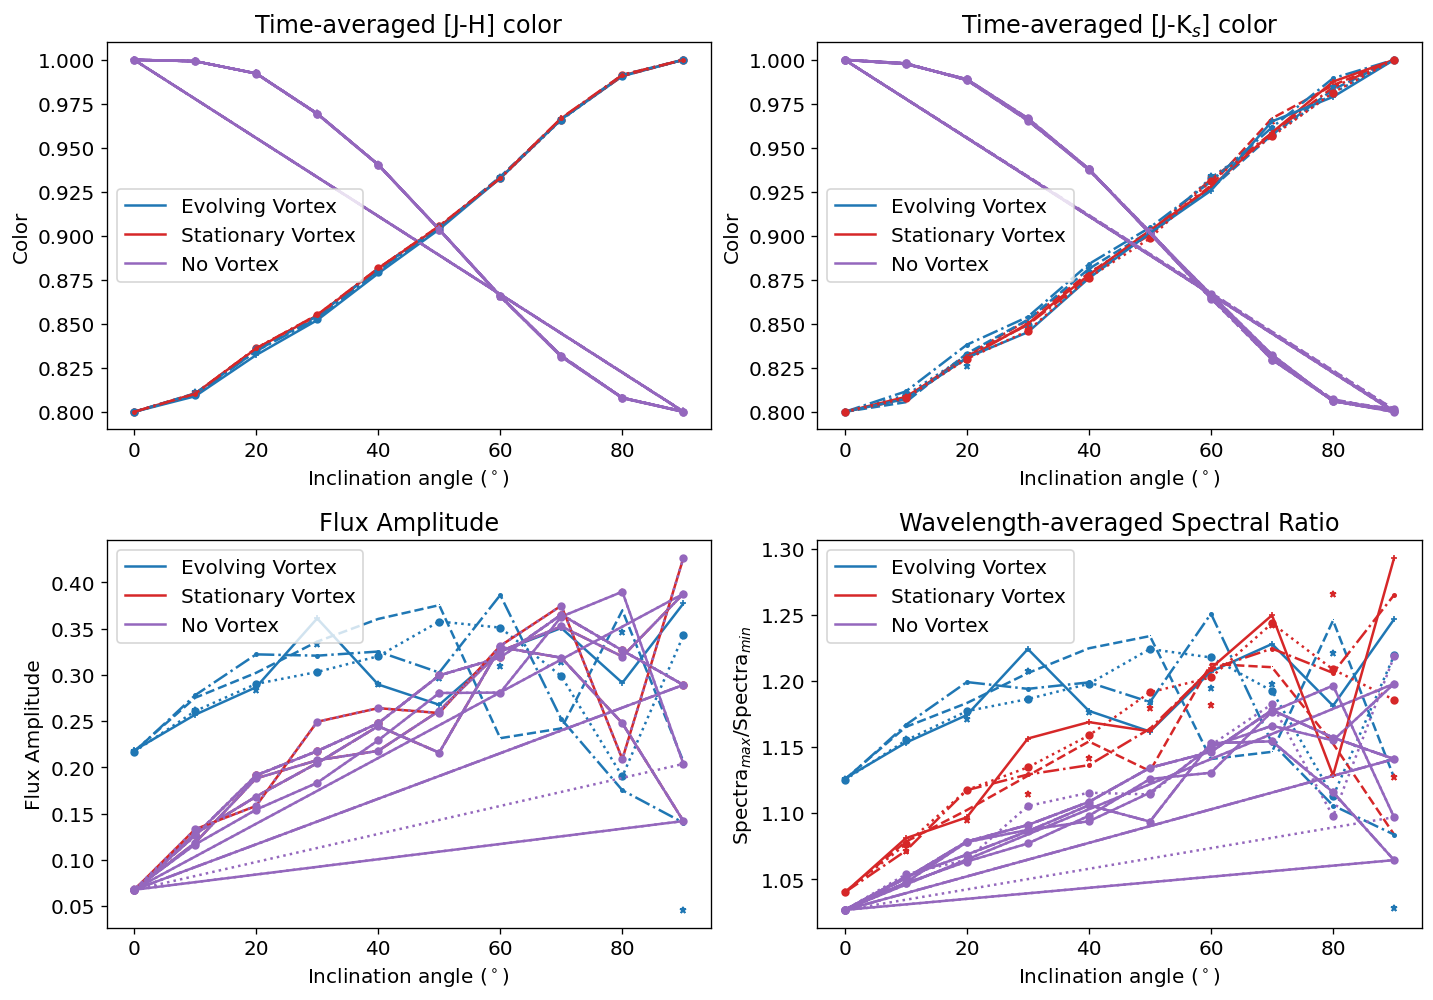

In [71]:
# ==========================================================
## The plot: composite J-H, J-K color, and silicate Index
# ==========================================================
save = False
# save = True

titles = ['Stationary polar vortex', 'Evolving polar vortex', 'No vortex']
fig, axs = plt.subplots(2, 2, figsize=(12, 8.5), dpi=120)
plt.rcParams.update({'font.size': 12})

colorList = {'polarStatic':'tab:blue', 'polarDynamic':'k', 'noPolar':'tab:red', 'nothing':'tab:purple'}
colorAlias = {'JH_color':'Time-averaged [J-H] color', 'JK_color':r'Time-averaged [J-K$_s$] color', 'silicateIndex':'Si-index'}
markers = ['*', 's','^']
msizes = [11, 9.5, 7]
for counter in range(len(production_keys)):
    for n, typename in enumerate(['JH_color', 'JK_color']):
        for i, model in enumerate(['polarStatic', 'noPolar', 'nothing']):
            line, mark = next(linestyleRandomList), next(markerRandomList)
            
            x = amplitudes[model][counter][typename][:,0]
            y = amplitudes[model][counter][typename][:,1]

            # rescaling
            scale, offset = np.linalg.solve(b=(0.8, 1.0), a=((np.min(y), 1), (np.max(y), 1)))

            axs[0,n].plot(x+90, y*scale + offset, ls=next(linestyleRandomList), marker=next(markerRandomList), 
                          c=colorList[model], ms=4)

            if n==0:
                y2 = amplitudes[model][counter]['flux'][:,1]
                y3 = amplitudes[model][counter]['specRatio'][:,1]
                axs[1,0].plot(x+90, y2, ls=line, marker=mark, c=colorList[model], ms=4)
                axs[1,1].plot(x+90, y3, ls=line, marker=mark, c=colorList[model], ms=4)
                
                if counter == 0:
                    axs[1,0].plot([], [], ls='-', c=colorList[model], label=aliasList[model])
                    axs[1,1].plot([], [], ls='-', c=colorList[model], label=aliasList[model])
                    axs[0,0].plot([], [], ls='-', c=colorList[model], label=aliasList[model])
                    axs[0,1].plot([], [], ls='-', c=colorList[model], label=aliasList[model])
                
        axs[1,0].legend(), axs[1,1].legend()
        axs[0,n].legend()
        axs[1,n].set_xlabel(r'Inclination angle ($^\circ$)')
        axs[0,n].set_xlabel(r'Inclination angle ($^\circ$)')
        axs[0,n].set_title(colorAlias[typename])

axs[0,0].set_ylabel('Color')
axs[0,1].set_ylabel('Color')
axs[1,0].set_ylabel('Flux Amplitude')
axs[1,1].set_ylabel(r'Spectra$_{max}$/Spectra$_{min}$')
axs[1,0].set_title('Flux Amplitude')
axs[1,1].set_title('Wavelength-averaged Spectral Ratio')

# # text notation
# fs = 10
# # J-h plot
# axs[0,0].set_ylim(0.75, 1.05)
# axs[0,0].text(2, 0.76, 'Pole-on', fontsize=fs), axs[0,0].text(75, 0.76, 'Equator-on', fontsize=fs)
# axs[0,0].text(0, 1.02, 'A)', fontsize=15, weight='bold')
# # J-k plot
# axs[0,1].set_ylim(0.75, 1.05)
# axs[0,1].text(2, 0.76, 'Pole-on', fontsize=fs), axs[0,1].text(75, 0.76, 'Equator-on', fontsize=fs)
# axs[0,1].text(0, 1.02, 'B)', fontsize=15, weight='bold')
# # flux amp plot
# axs[1,0].text(5, 0.065, 'Pole-on', fontsize=fs), axs[1,0].text(75, 0.065, 'Equator-on', fontsize=fs)
# axs[1,0].text(0, 0.3, 'C)', fontsize=15, weight='bold')
# # spec ratio plot
# axs[1,1].text(5, 1.025, 'Pole-on', fontsize=fs), axs[1,1].text(75, 1.025, 'Equator-on', fontsize=fs)
# axs[1,1].text(0, 1.175, 'D)', fontsize=15, weight='bold')

plt.tight_layout()

if save:
    plotOut = plotPath + '/[extraThird]2x2_JH_JK_inclinationTrend'
    plt.savefig(plotOut+'.pdf', dpi=300, format='pdf', bbox_inches = 'tight')
    plt.savefig(plotOut+'.png', dpi=300, format='png', bbox_inches = 'tight')

## Step 5: Understanding the *Variability-Inclination* Trend  

#### 5A) [read]: external variability 3.6 and 4.5um from Spitzer

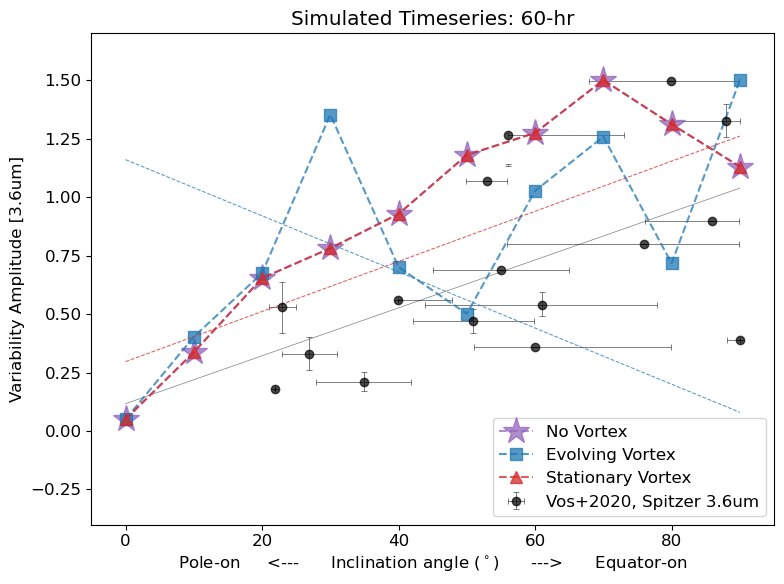

In [44]:
save = True
# save = False

vos20Variab36Path = "~/Documents/GitHub/polar_vortice/PolarVortice/spitzerData/variability/vos2020_fig11_variability3.6.csv"
nameList2 = ['Variability', 'Inclination', 'xerr1', 'xerr2', 'yerr1', 'yerr2']

vos20Variab36 = pd.read_csv(vos20Variab36Path, names=nameList2, delimiter=',', skiprows=1)

# ======== edit nan values =========
vos20Variab36['yerr1'][np.isnan(vos20Variab36['yerr1'])] = vos20Variab36['Inclination'][np.isnan(vos20Variab36['yerr1'])]
vos20Variab36['yerr2'][np.isnan(vos20Variab36['yerr2'])] = vos20Variab36['Inclination'][np.isnan(vos20Variab36['yerr2'])]
# vos20Variab36['yerr1'], vos20Variab36['yerr2']
vos20Variab36['xerr1'][np.isnan(vos20Variab36['xerr1'])] = vos20Variab36['Variability'][np.isnan(vos20Variab36['xerr1'])]
vos20Variab36['xerr2'][np.isnan(vos20Variab36['xerr2'])] = vos20Variab36['Variability'][np.isnan(vos20Variab36['xerr2'])]
# vos20Variab36['xerr1'], vos20Variab36['xerr2']
# ===================================

vos20Variab36['inclinationErr1'] = vos20Variab36['Inclination'] - vos20Variab36['yerr1']
vos20Variab36['inclinationErr2'] = vos20Variab36['yerr2'] - vos20Variab36['Inclination']
                                                             
vos20Variab36['variabErr1'] = vos20Variab36['Variability'] - vos20Variab36['xerr1']
vos20Variab36['variabErr2'] = vos20Variab36['xerr2'] - vos20Variab36['Variability']

colorList = {'polarStatic':'tab:blue', 'polarDynamic':'k', 'noPolar':'tab:red', 'nothing':'tab:purple'}

# =========== plot a J-K color - inclination diagram ===========
plt.close()
fig, (ax1) = plt.subplots(dpi=100, figsize=(8,6))
ax1.set_title('Simulated Timeseries: 60-hr')

inclination = vos20Variab36['Inclination'].copy()
variab36 = vos20Variab36['Variability'].copy()

incliErr = (vos20Variab36['inclinationErr1'].tolist(),
       vos20Variab36['inclinationErr2'].tolist())

variabErr = (vos20Variab36['variabErr1'].tolist(),
       vos20Variab36['variabErr2'].tolist())

ax1.errorbar(x=inclination, y=variab36, xerr=incliErr, yerr=variabErr, 
            ls='', marker='o', lw=0.5, capsize=2, capthick=0.5, c='k', alpha=0.7,
            label='Vos+2020, Spitzer 3.6um')

coef = np.polyfit(inclination, variab36, 1)
linear_fn = np.poly1d(coef) 
xtest = np.linspace(0,90,50)
ax1.plot(xtest, linear_fn(xtest), lw=0.5, alpha=0.5, c='k')

msizes = [20, 8, 8]
for i, model in enumerate(['nothing', 'polarStatic', 'noPolar']):
    x = amplitudes[model]['flux'][:,0]
    y = amplitudes[model]['flux'][:,1]
    # rescaling
    scale, offset = 0.5*np.linalg.solve(b=(0.1, 3), a=((np.min(y), 1), (np.max(y), 1)))
    ax1.plot(x+90, y*scale + offset, ls='--', marker=markers[i], 
                  c=colorList[model], ms=msizes[i], label=aliasList[model], alpha=0.75)

ax1.set_yscale('linear')
ax1.set_ylim(-0.4, 1.7)
ax1.set_xlim(-5, 95)
ax1.set_xlabel(r'Pole-on     <---      Inclination angle ($^\circ$)      --->      Equator-on')
ax1.set_ylabel('Variability Amplitude [3.6um]')
ax1.legend()

# manual regressions
a1, b1 = np.polyfit([5, 75], [0.35, 1.1], 1)
a2, b2 = np.polyfit([5, 80], [1.1, 0.2], 1)
ax1.plot(xtest, a1*xtest + b1, c='tab:red', lw=0.75, alpha=0.75, ls='--')
ax1.plot(xtest, a2*xtest + b2, c='tab:blue', lw=0.75, alpha=0.75, ls='--')

plt.tight_layout()

if save:
    plotOut = plotPath + '/variability_inclinationTrend[production1][60hour]'
    plt.savefig(plotOut+'.pdf', dpi=300, format='pdf', bbox_inches = 'tight')
    plt.savefig(plotOut+'.png', dpi=300, format='png', bbox_inches = 'tight')